In [1]:
#if jupyternotify is installed, we can add %notify to a cell to get an alert when it ifnished running
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import metrics_helpers as indicators
import pickle as pk
import gc
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import traceback #needed to store full error tracebacks

In [3]:
from pathlib import Path
import os

In [4]:
def dt_to_int(dt): #datetime to integer
    return dt.astype('int')/(10**9)

In [5]:
### filename/locations
file_location = '/Users/sma/Documents/INRAE internship/temppics/'

#### Load Data and Prepare Functions

In [6]:
with open('/Users/sma/Documents/INRAE internship/scrape-git/facebook/untypod_dict.pkl', 'rb') as f:
    netmums = pk.load(f)      
#FIXME: modify location of untypod_dict !

In [7]:
nm_ind = indicators.indicators(netmums, fb=False)
#this one takes long, around 20 seconds I think.

posts_dict = nm_ind.get_posts_dict()

In [8]:
hazards = {
'Chemical contaminants': [],
'Endocrine disruptor': ["endocrine","estrogen"],
'FOOD PRESERVATIVES, SWEETENERS AND ADDITIVES':["preservatives","sweeteners","additives"],
"Pesticides":[],
"Veterinary drugs":["animal drugs","vet drugs"],
'GMO':['GM',"genetically modified"],
"Metals":[],
"Mycotoxin":[],
"Bisphenol A":['BPA','Bisphenol','BisphenolA'],
'Furan':[],
'DON': #(note that this acronym nobody uses and all results are from words like "don't")
["deoxynivalenol",
"vomitoxin"],
'DIOXIN AND PCB':["Dioxin","PCB","biphenyls"],
'MOSH and MOAH':["hydrocarbons","saturated hydrocarbons","MOAH", 'MOH',"aromatic hydrocarbons"],
'Nitrates':[],
"Acrylamid":["Acrylamide"],
"phthalates":[],
"Microbiologic contaminants":
["spores",
"mold",
"mould",
#"virus",
"microbes",
"contaminated"],
"Salmonella":[],
"Campylobacter":[],
"Listeria":[],
"EColi":["E-coli"],
"Cronobacter":[],
"Histamine":[],
'other bacteria':["bacteria"],
"Virus":[],
"Parasites":[],
'Related Terms':["carcinogen","chemicals", "toxic", "toxin", "poisonous", "fungus", "food poisoning", "hazard","EFSA","European Food Safety Authority"]
}

products = {
'infant formula':
["formula","baby formula", "bottle-fed", "bottle"]
,'sterilized vegetable mixed with fish':
["veggie baby food","vegetable baby food",
"veg puree", "veg purée"]
,'fresh fruit puree mildly processed':
["fruit puree","fruit baby food", "fruit purée", "applesauce", "apple sauce", "fruit sauce"]
,'infant cereals':
["cereal for baby", "cereal", "porridge", "oats", "oatmeal"]
,'other':
["jar food", "baby food", "jarred", "premade food", "puree", "purée", "jarred food"
,"yoghurt", "pudding"]
}


#IMPORTANT!: terms used for count vectorizer must be lower-case o.w. get 0 matches
hazards = {key.lower():[v.lower() for v in value] + [key.lower()] for key,value in hazards.items()}
products = {key.lower():[v.lower() for v in value]+[key.lower()] for key,value in products.items()}

In [9]:

extras = {\
'baby_food_brands':
['ellas',
'organix',
'heinz baby',
"plum baby",
'little angels',
'farleys'],
'formula_brands':['sma','aptamil comfort','infasoy','nutramigen','neocate','powdered milk','comfort milk'],
 'food_or_formula_brands':
['aptamil', # formula and cereals.
'hipp organic',# - formula and baby food
'cow gate','cow and gate','c g',
'mamia'],
##NON BRAND SIGNALS##
'cereal':['baby_cereal','baby riceporridge','baby rice','baby porridge'],
'baby_food':['mashed','tinned','premade','canned','jarred','pouches','pouch','ready made','readymade','cartons'],  
#INDICATORS TO BE USED IN CONJUNCTION WITH 'baby food' label: this way we 
#can observe if both terms are used in a document (but are not used right next to each other.)
'fruit':['fruit'],
'vegetable':['vegetable'],
'baby':['infant', 'baby' ,'for littles']
         }


In [10]:
import re

def make_phrases(list_of_phrases, text):
    """
    convert phrases to bigrams within a larger text corpus.
    example: "I love collard greens for breakfast" -> "I love collard_greens for breakfast"
    example: "I love collard-greens for breakfast" -> "I love collard_greens for breakfast"
    """
    for phrase in list_of_phrases:
        #spaces
        text = re.sub(phrase, re.sub(' ', '_',phrase), text)
        #hyphens
        text = re.sub(re.sub(' ', '-', phrase), re.sub(' ', '_',phrase), text)
    return text

def make_underscores(item):
    """
    recursively replace spaces and hyphens in strings, lists, sets, or other iterables.
    Return the same type if string, list, set. If other type, returns list.
    """
    if type(item) is str:
        return re.sub(' |-', '_', item)
    else:
        temp = []
        for thing in item:
            temp.append(make_underscores(thing))
    if type(item) is set:
        return set(temp)
    elif type(item) is list:
        return temp
    elif isinstance(item, type({}.keys())):
        #if the object is a dict.key() view
        return temp
    else:
        print('Object must be string, list, set, or dict.keys()')
    #TODO this would be cleaner if i just check that it's iterable, and then check that it's a string.

In [11]:
#from the dict which representes our subcategories, create lists of all words in the subcategories.
h = [item for val in hazards.values() for item in val]
p = [item for val in products.values() for item in val]
e = [item for val in extras.values() for item in val]

#### Generate & Process Text Dict

In [12]:

#concatenate list of all phrases (bigrams, anything with a space in it)
phrases = {'baby formula', 'baby cereal'}.union({item for item in p + h + e if ' ' in item})

#step 1: make a dict of just the text
text_dict = {key:value['body'] for key,value in posts_dict.items()}

#step 2 : convert the relevant phrases to bigrams with re.sub
text_dict = {key: make_phrases(phrases, text) for key, text in text_dict.items()}

#replace "don't" with "do not" (so that we don't get false positives for don count.)
for key in text_dict:
    text_dict[key] = re.sub('don[\W]+t', 'do not', text_dict[key], flags=re.I) #TODO. there are cases of "don' " need to catch.


#### Run Vectorizers

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#step 3: count occurences using countvectorizer
vocab = p + h + e
vocab = [re.sub(' |-','_',item) for item in vocab] #should I use make_underscores instead??
vocab = set(vocab) #remove duplicates
term_counter = CountVectorizer(vocabulary = vocab, stop_words = 'english')
counts = term_counter.fit_transform(text_dict.values())

#step4: take a sample of other words, we can use this as control and check for correlations with our terms.

#step 4.0: build stop words to include the main topics (hazard & products.)
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(vocab)

size_of_these_vec = 100
all_term_counter_max = CountVectorizer(stop_words = 'english', max_features= size_of_these_vec)
    #limit to terms with certain tf-idf count
all_term_counter_maxdf = CountVectorizer(stop_words = 'english', max_features= size_of_these_vec, max_df = 0.03)

#step 4.25: take entire countvectorizer so we can filter by part of speech after tagging with pos-tagger
from nltk import pos_tag as part_of_speech 
#NOTE IF THERE's A PROBLEM make sure to run nltk.download('averaged_perceptron_tagger')
full_counter = CountVectorizer(stop_words = 'english')
all_words = full_counter.fit_transform(text_dict.values())
t = part_of_speech(full_counter.vocabulary_.keys()) #tag part of speech
non_noun_vocab = [i[0] for i in t if i[1] not in ['NN', 'NNS']] #keep all POS that ARE NOT noun or plural noun
noun_stop_words = stopwords.words('english')
noun_stop_words.extend(vocab)
noun_stop_words.extend(non_noun_vocab) #add all the words to list of stop words
#(list of possible tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html )

#define the countvec
noun_counter_maxdf = CountVectorizer(stop_words=noun_stop_words, max_df = 0.01, min_df = 10, max_features = 5 * size_of_these_vec)

#step 4.75: generate counts!

max_counts = all_term_counter_max.fit_transform(text_dict.values())
maxdf_counts = all_term_counter_maxdf.fit_transform(text_dict.values())
noundf_counts = noun_counter_maxdf.fit_transform(text_dict.values())

#note that hyphens will be treated as spaces by countvectorizer

/usr/local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['_sweeteners_and_additives', 'food_preservatives'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [14]:
def dict_from_arr(counts, counter, the_dict:dict): #recent change: i made the_dict an item in function.
    if type(counts) is not np.ndarray:
        counts = counts.toarray() #convert from sparse array to np array if it hasn't already.
    count_dict = {}    #initialize dict
    for num, key in enumerate(the_dict.keys()):
        count_dict[key] = {term: counts[num][value] for term, value in counter.vocabulary_.items()}
    return count_dict

In [15]:
countdf = pd.DataFrame.from_dict(dict_from_arr(counts, term_counter, text_dict)).transpose()
countdf

acrylamid  acrylamide  \
https://www.netmums.com/coffeehouse/becoming-mu... 0          0           0   
                                                   1          0           0   
                                                   2          0           0   
                                                   3          0           0   
                                                   4          0           0   
...                                                         ...         ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5          0           0   
                                                   6          0           0   
                                                   7          0           0   
                                                   8          0           0   
                                                   9          0           0   

                                                      additives  animal_drugs  \
https://www.netmums.com/coffeehouse/becoming-mu... 0          0             0   
                                                   1          0             0   
                                                   2          0             0   
                                                   3          0             0   
                                                   4          0             0   
...                                                         ...           ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5          0             0   
                                                   6          0             0   
                                                   7          0             0   
                                                   8          0             0   
                                                   9          0             0   

                                                      apple_sauce  applesauce  \
https://www.netmums.com/coffeehouse/becoming-mu... 0            0           0   
                                                   1            0           0   
                                                   2            0           0   
                                                   3            0           0   
                                                   4            0           0   
...                                                           ...         ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5            0           0   
                                                   6            0           0   
                                                   7            0           0   
                                                   8            0           0   
                                                   9            0           0   

                                                      aptamil  \
https://www.netmums.com/coffeehouse/becoming-mu... 0        0   
                                                   1        0   
                                                   2        0   
                                                   3        0   
                                                   4        0   
...                                                       ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5        0   
                                                   6        0   
                                                   7        0   
                                                   8        0   
                                                   9        0   

                                                      aptamil_comfort  \
https://www.netmums.com/coffeehouse/becoming-mu... 0                0   
                                                   1                0   
                                                   2                0   
                                                   3                0   
             

In [16]:
maxcountdf = pd.DataFrame.from_dict(dict_from_arr(max_counts, all_term_counter_max, text_dict)).transpose()

In [17]:
maxdfcountdf = pd.DataFrame.from_dict(dict_from_arr(maxdf_counts, all_term_counter_maxdf, text_dict)).transpose()

In [18]:
noundfcountdf = pd.DataFrame.from_dict(dict_from_arr(noundf_counts, noun_counter_maxdf, text_dict)).transpose()

#### Meta: Check if our groupings of hazard terms are good..

if terms are highly correlated with unrelated terms this could be bad.
if terms are indepndent of their related terms thsi is not bad, it means they are finding extra posts.
if terms are correlated with tehir related terms this is not bad and indicates the terms are used in the same post.

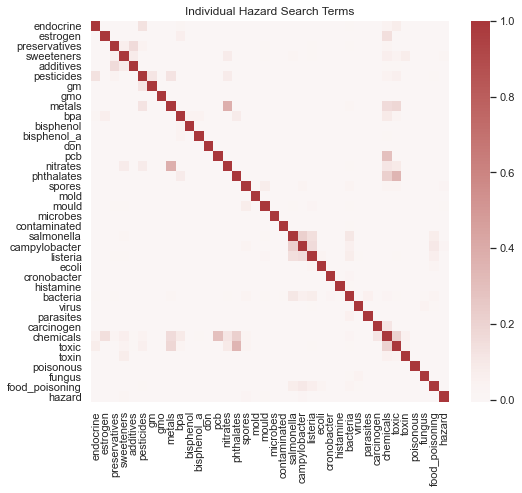

In [19]:
sns.set(rc={'figure.figsize':(8,7)})
fig = sns.heatmap(countdf[make_underscores(h)].corr().dropna(axis=0, how='all').dropna(axis=1,how='all'), \
            cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)
plt.title('Individual Hazard Search Terms')
os.makedirs(Path(file_location + 'heatmaps'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'heatmaps/individual_terms.png'), bbox_inches="tight")

#### Create a by-Sentence dict (for Sentence-Post Mixed Effect Regression Model way at the bottom)

In [20]:
def split_sentences(text:str):
    return re.findall('.*?[\n?!.]+', text) #match the bracketed items with the text prefixing it. 

#create dict 
#keys in the form (thread url, post num, sent num)
sent_dict = {(key[0], key[1], ind): sent for key,value in text_dict.items() for ind,sent in enumerate(split_sentences(value))}
#only takes like 2 seconds 

##### Run the same vectorization and generate DataFrame

In [21]:
sent_counts = term_counter.fit_transform(sent_dict.values())

#sent_max_counts = all_term_counter_max.fit_transform(sent_dict.values())
#sent_maxdf_counts = all_term_counter_maxdf.fit_transform(sent_dict.values())
sent_noundf_counts = noun_counter_maxdf.fit_transform(sent_dict.values())

In [22]:
sent_df = pd.DataFrame.from_dict(dict_from_arr(sent_counts, term_counter, sent_dict)).transpose()

In [23]:
sent_noun_df = pd.DataFrame.from_dict(dict_from_arr(sent_noundf_counts, noun_counter_maxdf, sent_dict)).transpose()

### Check Correlations from Counts (for Post dataframe)

In [24]:
def get_relevant_correlations(corr_data: pd.DataFrame, p_values: pd.DataFrame, alpha=0.05, cutoff = 0.1):
    #apply rejection rule to p-values
    rej = (p_values < 0.05).astype(int)
    #set correlation to 0 if null hypothesis not rejected.
    corr_data = corr_data * rej
    
    
    grouped_series = [] 
    pd.DataFrame(corr_data.stack()[abs(corr_data.stack()) >= cutoff].sort_values(ascending=False)
            ).sort_index(level=1
                      ).groupby(level=1).apply(lambda a: grouped_series.append(a.unstack(level=1)))
    
    grouped_p_values = [] 
    pd.DataFrame(p_values.stack()[abs(corr_data.stack()) >= cutoff].sort_values(ascending=False)
            ).sort_index(level=1
                      ).groupby(level=1).apply(lambda a: grouped_p_values.append(a.unstack(level=1)))
    return grouped_series, grouped_p_values

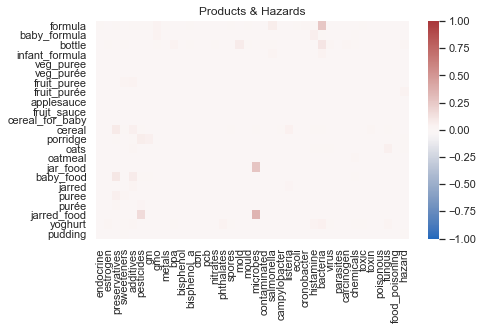

In [25]:
sns.set(rc={'figure.figsize':(7,4)})
fig = sns.heatmap(countdf.corr().loc[make_underscores(p), make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all'), \
           cmap= "vlag", vmax=1.0, vmin=-1.0, center=0.00, xticklabels=True, yticklabels=True)
plt.title('Products & Hazards')

os.makedirs(Path(file_location + 'heatmaps'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'heatmaps/prod_haz.png'), bbox_inches="tight")

In [26]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [27]:
#p-values
p_value_data = calculate_pvalues(countdf).loc[make_underscores(p), make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all')
#correlation
correlation_data = countdf.corr().loc[make_underscores(p), make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all')
corr_list, p_list = get_relevant_correlations(correlation_data, p_value_data)

/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [28]:
tex = '\n'.join([i.to_latex() for i in corr_list])

os.makedirs(Path(file_location + 'correlation'), exist_ok=True)
with open(Path(file_location + 'correlation/prod_haz_corr.tex'), 'w') as f:
        f.write(tex)

In [29]:
temp_concat_df = pd.concat([countdf, maxcountdf], axis=1)
temp_concat_df = temp_concat_df.loc[:,~temp_concat_df.columns.duplicated()]
correlation_data = temp_concat_df.corr().loc[maxcountdf.columns, make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all')

p_value_data = calculate_pvalues(temp_concat_df).loc[maxcountdf.columns, make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all')


corr_list, p_list = get_relevant_correlations(correlation_data, p_value_data)

/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [30]:
tex = '\n'.join([i.to_latex() for i in corr_list])

os.makedirs(Path(file_location + 'correlation'), exist_ok=True)
with open(Path(file_location + 'correlation/hazard_maxcountofftopic.tex'), 'w') as f:
        f.write(tex)
#sns.set(rc={'figure.figsize':(17,5)})
#sns.heatmap(temp_concat_df.corr().loc[make_underscores(h), maxcountdf.columns].dropna(axis=0, how='all').dropna(axis=1,how='all'), \
#            cmap= "vlag", vmax=1.0, vmin=-1.0, center=0.00, xticklabels=True, yticklabels=True)

In [31]:
temp_concat_df = pd.concat([countdf, maxdfcountdf], axis=1)
temp_concat_df = temp_concat_df.loc[:,~temp_concat_df.columns.duplicated()]
correlation_data = temp_concat_df.corr().loc[maxdfcountdf.columns, make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all')

p_value_data = calculate_pvalues(temp_concat_df).loc[maxdfcountdf.columns, make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all')


corr_list, p_list = get_relevant_correlations(correlation_data, p_value_data)



tex = '\n'.join([i.to_latex() for i in corr_list])

os.makedirs(Path(file_location + 'correlation'), exist_ok=True)
with open(Path(file_location + 'correlation/hazard_maxdfcountofftopic.tex'), 'w') as f:
        f.write(tex)
#sns.set(rc={'figure.figsize':(17,6)})
#sns.heatmap(temp_concat_df.corr().loc[make_underscores(h), maxdfcountdf.columns].dropna(axis=0, how='all').dropna(axis=1,how='all'), \
#            cmap= "vlag", vmax=1.0, vmin=-1.0, center=0.00, xticklabels=True, yticklabels=True)
#plt.title('Hazards & TF-IDF Filtered Counts')

/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [32]:
temp_concat_df = pd.concat([countdf, noundfcountdf], axis=1)
temp_concat_df = temp_concat_df.loc[:,~temp_concat_df.columns.duplicated()]

#sns.set(rc={'figure.figsize':(6, 82)})
#sns.heatmap(temp_concat_df.corr().loc[noundfcountdf.columns, make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all'), \
#            cmap= "vlag", vmax=1.0, vmin=-1.0, center=0.00, xticklabels=True, yticklabels=True)
#plt.title('Hazards & Noun + DF Filtered Counts')

In [33]:
correlation_data = temp_concat_df.corr().loc[noundfcountdf.columns, make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all')
p_value_data = calculate_pvalues(temp_concat_df).loc[noundfcountdf.columns, make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all')


/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [34]:
corr_list, p_list = get_relevant_correlations(correlation_data, p_value_data)

In [35]:
tex = '\n'.join([i.to_latex() for i in corr_list])

os.makedirs(Path(file_location + 'correlation'), exist_ok=True)
with open(Path(file_location + 'correlation/hazard_nouncountofftopic.tex'), 'w') as f:
        f.write(tex)

## Join Data into Single DataFrame

In [36]:
summed_df = pd.DataFrame()

for key in products.keys():
    summed_df[key] = countdf[make_underscores(products[key])].sum(axis=1)
for key in hazards.keys():
    summed_df[key] = countdf[make_underscores(hazards[key])].sum(axis=1)
for key in extras.keys():
    summed_df[key] = countdf[make_underscores(extras[key])].sum(axis=1)

### process the fruit, vegetable, baby columns

Idea: we only want to count mentions of fruit in the context of baby food. So we take the count of fruit and multiply it by the whether the mentions of baby are non-zero or not.

In [37]:
#count mentions of fruit or vegetable
#return 0 if there is no words indicating a context of BABY foods (not adult foods)
#note that baby food brand names occur much more than fruit or veg. Am not sure if they co-occur.
#TODO: maybe it is better to add the brands in with the fruit / veg. But since it is highly corr with them alreayd, at least looking by post it isnt a problem
summed_df['fruit_in_baby_context'] = summed_df['fruit']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)
summed_df['veg_in_baby_context'] = summed_df['vegetable']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)

#if there is mention of fruit or vegetable it's not uncategorized. return 0
# if no mentions, sum the counts of mentions of baby food brands
# possible improvement: check for words indicating a food, or in weaning forum etc. THEN we can also add food_or_formula_brands to the COUNT.
summed_df['baby_food_uncategorized'] = (summed_df[['fruit','vegetable']].sum(axis=1) > 0) * summed_df['baby_food_brands']

In [38]:
class_df = summed_df.copy()

In [39]:
product_cols = list(products.keys()) + ['veg_in_baby_context', 'fruit_in_baby_context', 'baby_food_uncategorized']

### Repeat for the Sentence DF

In [40]:
summed_sent_df = pd.DataFrame()

for key in products.keys():
    summed_sent_df[key] = sent_df[make_underscores(products[key])].sum(axis=1)
for key in hazards.keys():
    summed_sent_df[key] = sent_df[make_underscores(hazards[key])].sum(axis=1)
for key in extras.keys():
    summed_sent_df[key] = sent_df[make_underscores(extras[key])].sum(axis=1)
    
summed_sent_df['fruit_in_baby_context'] = summed_sent_df['fruit']  * (summed_sent_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)
summed_sent_df['veg_in_baby_context'] = summed_sent_df['vegetable']  * (summed_sent_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)

#if there is mention of fruit or vegetable it's not uncategorized. return 0
# if no mentions, sum the counts of mentions of baby food brands
# possible improvement: check for words indicating a food, or in weaning forum etc. THEN we can also add food_or_formula_brands to the COUNT.
summed_sent_df['baby_food_uncategorized'] = (summed_sent_df[['fruit','vegetable']].sum(axis=1) > 0) * summed_sent_df['baby_food_brands']

class_sent_df = summed_sent_df.copy()

# Classify

## Count Approach

In [41]:
#classify
class_df['product_type'] = class_df[product_cols].idxmax(axis=1)
# idxmax has a strange behavior where it will set all-zero sets to an arbitrary category (the first one available?)
# so we must manually change them to an NA category.
class_df.loc[class_df[product_cols].max(axis=1) == 0,'product_type'] = 'NA'
# convert to categorical (factors)
class_df['product_type'] = class_df['product_type'].astype('category')

In [42]:
#make classification for hazards and check it as well.
class_df['hazard_type'] = class_df[hazards.keys()].idxmax(axis=1)
class_df.loc[class_df[hazards.keys()].max(axis=1) == 0,'hazard_type'] = 'NA'
class_df['hazard_type'] = class_df['hazard_type'].astype('category')

### Repeat for Sent DF

In [43]:

class_sent_df['product_type'] = class_sent_df[product_cols].idxmax(axis=1)

class_sent_df.loc[class_sent_df[product_cols].max(axis=1) == 0,'product_type'] = 'NA'

class_sent_df['product_type'] = class_sent_df['product_type'].astype('category')
class_sent_df['hazard_type'] = class_sent_df[hazards.keys()].idxmax(axis=1)
class_sent_df.loc[class_sent_df[hazards.keys()].max(axis=1) == 0,'hazard_type'] = 'NA'
class_sent_df['hazard_type'] = class_sent_df['hazard_type'].astype('category')

### Check the Resulting Totals

#### Total Count

In [44]:
#note: we have classified hazards but for this section it is not useful to look at, 
#we look further into it in later sections focusing on sentiment analysis.
class_df['hazard_type'].value_counts()

NA                                              18491
other bacteria                                    347
related terms                                     296
food preservatives, sweeteners and additives      113
microbiologic contaminants                        100
virus                                              79
bisphenol a                                        67
listeria                                           60
salmonella                                         36
pesticides                                         21
histamine                                          16
parasites                                          11
gmo                                                 8
campylobacter                                       8
endocrine disruptor                                 7
metals                                              3
ecoli                                               3
nitrates                                            2
phthalates                  

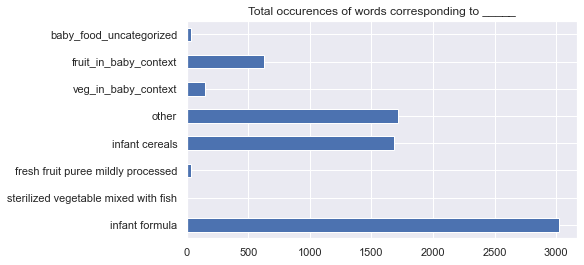

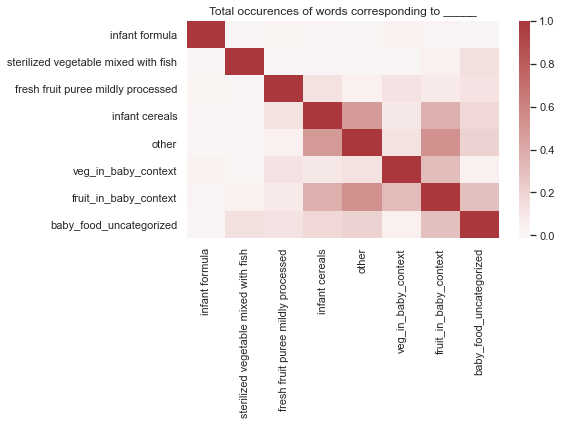

In [45]:
fig = class_df[product_cols].sum(axis=0).plot(kind='barh')
plt.title('Total occurences of words corresponding to _____')
plt.show()

os.makedirs(Path(file_location + 'counts'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'counts/product_total_occurence.png'), bbox_inches="tight")

fig = sns.heatmap(class_df[product_cols].corr(), cmap= "vlag", center=0.00)
plt.title('Total occurences of words corresponding to _____')
plt.show()
os.makedirs(Path(file_location + 'counts'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'counts/product_tot_occurence_corr.png'), bbox_inches="tight")

#### Number of Posts Containing an Occurence

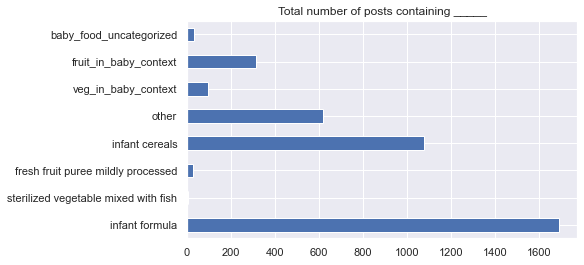

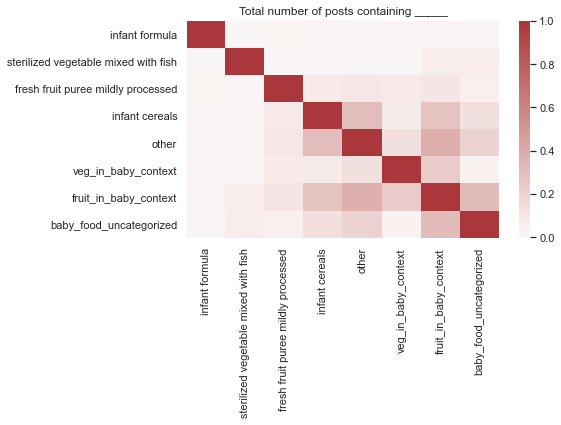

In [46]:
fig = (class_df[product_cols] > 0).sum(axis=0).plot(kind='barh')
plt.title('Total number of posts containing _____')
plt.show()
os.makedirs(Path(file_location + 'counts'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'counts/product_num_posts.png'), bbox_inches="tight")

fig = sns.heatmap((class_df[product_cols] > 0).corr(), cmap= "vlag", center=0.00)
plt.title('Total number of posts containing _____')
plt.show()
os.makedirs(Path(file_location + 'counts'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'counts/product_num_posts_corr.png'), bbox_inches="tight")

# Check the Classification

In [47]:
class_df['hazard_type'].value_counts()

NA                                              18491
other bacteria                                    347
related terms                                     296
food preservatives, sweeteners and additives      113
microbiologic contaminants                        100
virus                                              79
bisphenol a                                        67
listeria                                           60
salmonella                                         36
pesticides                                         21
histamine                                          16
parasites                                          11
gmo                                                 8
campylobacter                                       8
endocrine disruptor                                 7
metals                                              3
ecoli                                               3
nitrates                                            2
phthalates                  

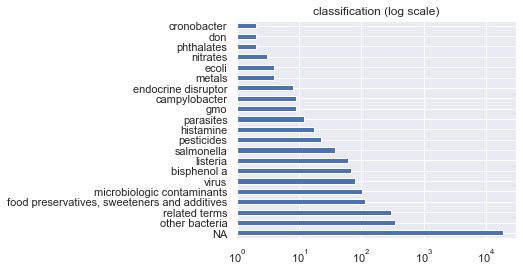

In [48]:
sns.set(rc={'figure.figsize':(5,4)})
fig = class_df['hazard_type'].value_counts().plot.barh(title='classification'+ ' (log scale)', log=True)
plt.show()
os.makedirs(Path(file_location + 'classification'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'classification/hazard_log.png'), bbox_inches="tight")


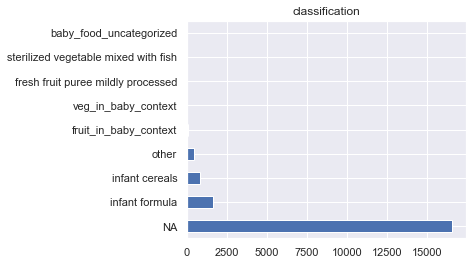

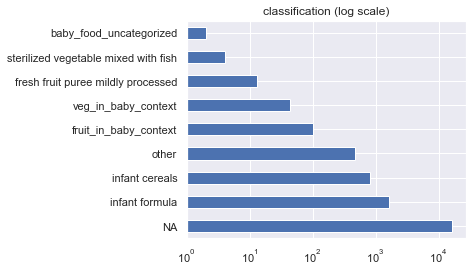

In [49]:
sns.set(rc={'figure.figsize':(5,4)})
fig = class_df['product_type'].value_counts().plot.barh(title = 'classification')
plt.show()

os.makedirs(Path(file_location + 'classification'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'classification/product.png'), bbox_inches="tight")


fig = class_df['product_type'].value_counts().plot.barh(title='classification'+ ' (log scale)', log=True)

plt.show()
os.makedirs(Path(file_location + 'classification'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'classification/product_log.png'), bbox_inches="tight")

## Hazard Occurences by Product Class

### Number of Occurences

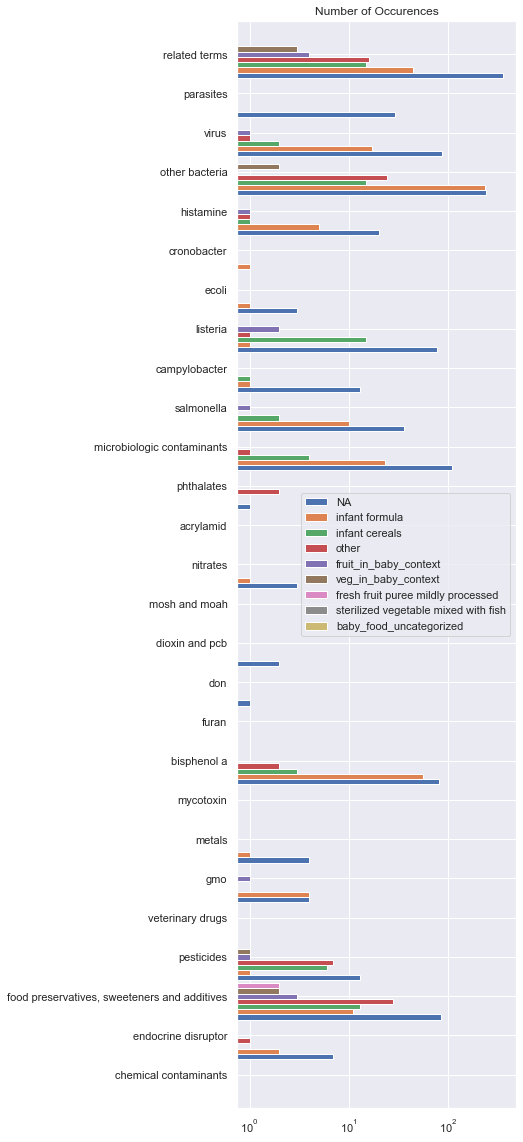

In [50]:
sns.set(rc={'figure.figsize':(5,20)})
fig = pd.DataFrame({category:class_df.loc[class_df.product_type == category][hazards.keys()].sum(axis=0) for category in class_df['product_type'].value_counts().index}).plot.barh(width=1.2,log=True)
plt.title('Number of Occurences')

plt.show()
os.makedirs(Path(file_location + 'classification'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'classification/prod_occurences_by_hazard.png'), bbox_inches="tight")

### Number of Posts Containing an Occurence

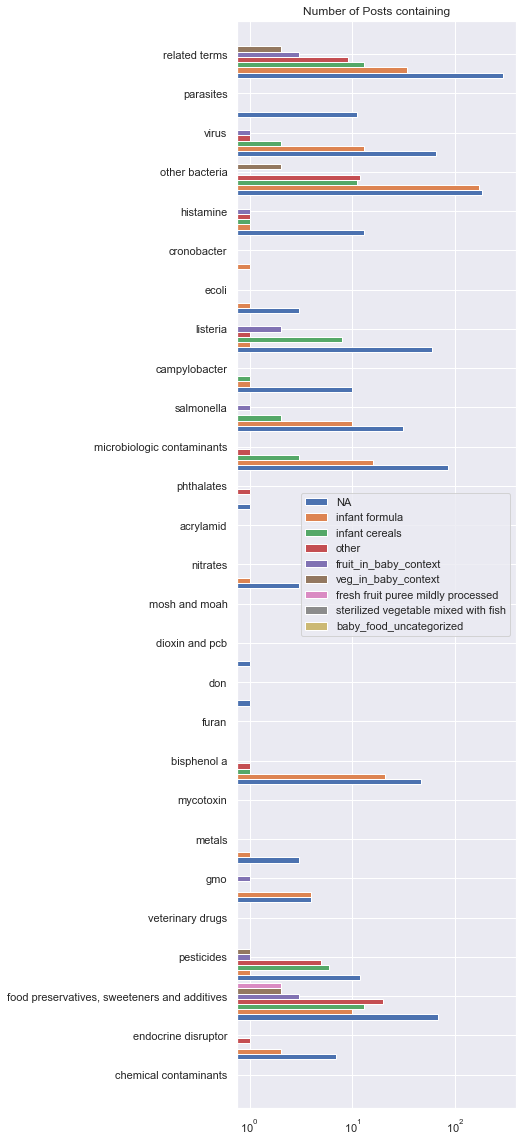

In [51]:
sns.set(rc={'figure.figsize':(5,20)})
pd.DataFrame({category:(class_df.loc[class_df.product_type == category][hazards.keys()] > 0).sum(axis=0) for category in class_df['product_type'].value_counts().index}).plot.barh(width=1.2,log=True)
plt.title('Number of Posts containing')

plt.show()
os.makedirs(Path(file_location + 'classification'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'classification/prod_occurences_by_hazard_numposts.png'), bbox_inches="tight")

#  Feature Extraction: Sentiment Analysis

## NLTK Vader Sentiment Analysis
https://www.nltk.org/howto/sentiment.html


* calculate sentiment for each post
* save it into dataframe.

The VADER algorithm outputs sentiment scores to 4 classes of sentiments https://github.com/nltk/nltk/blob/develop/nltk/sentiment/vader.py#L441:

* neg, neu, pos - ratios for proportions of text that fall in each category (negative, neutral, positive)
    * neg + neu + pos = 1
    * in [0,1]
    * IMPORTANTLY: these proportions represent the "raw categorization" of each lexical item (e.g., words, emoticons/emojis, or initialisms) into positve, negative, or neutral classes; they do not account for the VADER rule-based enhancements such as word-order sensitivity for sentiment-laden multi-word phrases, degree modifiers, word-shape amplifiers, punctuation amplifiers, negation polarity switches, or contrastive conjunction sensitivity.
* compound - composite score, with added VADER weightings and rules, and normalized
    * in [-1,1]

more details: https://github.com/cjhutto/vaderSentiment#about-the-scoring

In [52]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [53]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/sma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [54]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#initialize object
sid = SentimentIntensityAnalyzer()

In [55]:
def nltk_sentiments(text):
    """
    Split sentences, parse and get modality of sentences, then return the mean of the modalities. (or something, #TODO)
    We need to split sentences because sentence structure is parsed. In sentiment anal it uses bag of words instead #TODO: verify this. I know nltk uses bag of words
    """
    sentences = tokenize.sent_tokenize(text)
    #remove sentences which have no alphabet data, they will bias our results.
    #this could also remove emoticons but oh well.
    #TODO: add THE SAME cleaning into the patterns one.
    #TODO: add code to remove sentences which only contain the letter X (there is a LOT of these on netmums tbh.)
    sentences = [sentence for sentence in sentences if sentence.upper().isupper()]
    sentiments = [sid.polarity_scores(sentence) for sentence in sentences]
    try:
        sentiment_keys = list(sentiments[0].keys())
        means = {sentiment_keys[ind]: np.mean(nums) for ind,nums in enumerate(list(zip(*[list(i.values()) for i in sentiments])))}
        variances = {sentiment_keys[ind]: np.var(nums) for ind,nums in enumerate(list(zip(*[list(i.values()) for i in sentiments])))}
        return means, variances
    except IndexError:
        sad_dict = {'neg':None, 'neu': None, 'pos':None, 'compound':None}
        return sad_dict, sad_dict
        

In [56]:
#run it
start = time.time()
temp = [(key, nltk_sentiments(posts_dict[key]['body'])) for key in class_df.index] #TODO: change this to use text_dict.

keys, sentiments_by_sentence = zip(*temp)
end = time.time()


#the tuple contains [0]:mean, [1]:var, we assign 
#the means of each feature and the vars of each feature
#to a new columns in the dataframe.

class_df['nltk_neg_mean'], class_df['nltk_neg_var'] =  \
        pd.Series([i[0].get('neg') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('neg') for i in sentiments_by_sentence], index=keys)

class_df['nltk_neu_mean'], class_df['nltk_neu_var'] =  \
        pd.Series([i[0].get('neu') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('neu') for i in sentiments_by_sentence], index=keys)

class_df['nltk_pos_mean'], class_df['nltk_pos_var'] =  \
        pd.Series([i[0].get('pos') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('pos') for i in sentiments_by_sentence], index=keys)

class_df['nltk_compound_mean'], class_df['nltk_compound_var'] =  \
        pd.Series([i[0].get('compound') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('compound') for i in sentiments_by_sentence], index=keys)

print(end-start)

40.27984690666199


### Repeat for Sent DF

In [57]:
#run it
print('Calculating sentiments...')
start = time.time()
temp = [(key, nltk_sentiments(sent_dict[key])) for key in class_sent_df.index]

keys, sentiments_by_sentence = zip(*temp)
end = time.time()


#the tuple contains [0]:mean, [1]:var, we assign 
#the means of each feature and the vars of each feature
#to a new columns in the dataframe.

class_sent_df['nltk_neg_mean'], class_sent_df['nltk_neg_var'] =  \
        pd.Series([i[0].get('neg') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('neg') for i in sentiments_by_sentence], index=keys)

class_sent_df['nltk_neu_mean'], class_sent_df['nltk_neu_var'] =  \
        pd.Series([i[0].get('neu') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('neu') for i in sentiments_by_sentence], index=keys)

class_sent_df['nltk_pos_mean'], class_sent_df['nltk_pos_var'] =  \
        pd.Series([i[0].get('pos') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('pos') for i in sentiments_by_sentence], index=keys)

class_sent_df['nltk_compound_mean'], class_sent_df['nltk_compound_var'] =  \
        pd.Series([i[0].get('compound') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('compound') for i in sentiments_by_sentence], index=keys)

print('it took',end-start, 'seconds')

Calculating sentiments...
it took 81.5603199005127 seconds


## Patterns Measures
https://github.com/clips/pattern/wiki/pattern-en#sentiment
https://github.com/clips/pattern/wiki/pattern-en#mood--modality

* Sentiment - from -1 to 1
* Objectivity/Subjectivity - from 0 to 1
* Modality - from -1 to 1

mood simply has a grammar detection system and returns the first mood signalled by grammar that is detected in a sentence.

modality - "Epistemic modality" is used to express possibility (i.e. how truthful is what is being said).

 The modality() function was tested with BioScope and Wikipedia training data from CoNLL2010 Shared Task 1.
 See for example Morante, R., Van Asch, V., Daelemans, W. (2010):
 Memory-Based Resolution of In-Sentence Scopes of Hedge Cues
 http://www.aclweb.org/anthology/W/W10/W10-3006.pdf
 Sentences in the training corpus are labelled as "certain" or "uncertain".
 For Wikipedia sentences, 2000 "certain" and 2000 "uncertain":
 modality(sentence) > 0.5 => A 0.70 P 0.73 R 0.64 F1 0.68

In [58]:
from pattern.en import sentiment

In [59]:
#debug
sentiment([i for i in posts_dict.values()][0]['body'])

(0.1266666666666667, 0.6666666666666667)

In [60]:
#illustrate how we can check individual word values with pattern.
sentiment([i for i in posts_dict.values()][0]['body']).assessments

[(['easy'], 0.43333333333333335, 0.8333333333333334, None),
 (['huge'], 0.4000000000000001, 0.9, None),
 (["n't", 'fit'], -0.2, 0.4, None),
 ([':/'], -0.25, 1.0, 'mood'),
 (['thanks', '!'], 0.25, 0.2, None)]

In [61]:
#calculate sentiments using pattern
keys, sent_and_subj = zip(*[(key, sentiment(posts_dict[key]['body'])) for key in class_df.index])
subj, sent = zip(*sent_and_subj)
del sent_and_subj
#save it to dataframe.
class_df['sentiment'], class_df['subjectivity'] =  pd.Series(sent, index=keys), pd.Series(subj, index=keys)

In [62]:
from pattern.en import parse, Sentence
from pattern.en import modality, mood

In [63]:
#The current version (3.6) of pattern has been unmaintained and the fix for this has not been implemented.
#This is a hacky method of getting around the error
#I suggest that you modify the pattern package yourself as described here (https://github.com/clips/pattern/issues/308)

#This hacky fix is included in order to maintain compatibility for those who have just installed the package.
#
# If you ever get RuntimeError, just try to rerun that cell until it doesnt give an error and then the rest from there.

i = 0
j = 0
while i == 0: #WORKAROUND
    j += 1
    try:
        modality(Sentence(parse('''Please stop giving me StopIteration Error!''')))
        if j > 4:
            i += 1
        print('pattern.en said ok.')
    except RuntimeError:
        print('pattern.en said no.')
        pass

pattern.en said no.
pattern.en said no.
pattern.en said ok.
pattern.en said ok.
pattern.en said ok.


In [64]:
def split_sentences(text):
    sentence_separators = re.findall('[\n?!.]+', text) + ['']
    sentences = re.split('[\n?!.]+', text)
    for ind, _ in enumerate(sentence_separators): #we keep the punctuation which sep sentences bc question marks are used in modality calculation.
        sentences[ind] += sentence_separators[ind]
    return sentences

def parse_and_get_m(text, get_mood=False, get_modal=True):
    """
    Split sentences, parse and get modality of sentences, then return the mean of the modalities. (or something, #TODO)
    We need to split sentences because sentence structure is parsed. In sentiment anal it uses bag of words instead #TODO: verify this. I know nltk uses bag of words
    """
    sents= [Sentence(parse(s, lemmata=True)) for s in split_sentences(text)] #I don't think the punctuations are used in modality or mood detection.
    ## Debug note: i forgot to parse and convert to Sentence object, but it ran fine (same results too).
    ## But now on re-running and debugging due to an error mentioned above,
    ## it seems that it is slow, regardless if I parse sentences myself or not.
    if get_mood:
        if get_modal:
            return [(modality(s), mood(s)) for s in sents]
        else:
            return [ mood(s) for s in sents]
    elif get_modal:
        return [modality(s) for s in sents]
    else:
        return None
        

In [65]:
#run it
start = time.time()
try: #ANOTHER WORKAROUND for this package. It needs to be run twice. No idea why.
    temp = [(key, parse_and_get_m(posts_dict[key]['body'])) for key in class_df.index]
except:
    temp = [(key, parse_and_get_m(posts_dict[key]['body'])) for key in class_df.index]
keys, modalities_by_sentence = zip(*temp)
end = time.time()
%notify

#prepare datatypes and add to dataframe
mean, var = zip(*[(np.mean(x), np.var(x)) for x in modalities_by_sentence])
del modalities_by_sentence

class_df['modality_sentence_mean'], class_df['modality_sentence_var'] =  pd.Series(mean, index=keys), pd.Series(var, index=keys)

<IPython.core.display.Javascript object>

### Repeat for Sentence DF

In [66]:
#run it
start = time.time()
try: #ANOTHER WORKAROUND for this package. It needs to be run twice. No idea why.
    temp = [(key, parse_and_get_m(sent_dict[key])) for key in class_sent_df.index]
except:
    temp = [(key, parse_and_get_m(sent_dict[key])) for key in class_sent_df.index]
keys, modalities_by_sentence = zip(*temp)
end = time.time()
%notify

#prepare datatypes and add to dataframe
mean, var = zip(*[(np.mean(x), np.var(x)) for x in modalities_by_sentence])
del modalities_by_sentence

class_sent_df['modality_sentence_mean'], class_sent_df['modality_sentence_var'] =  pd.Series(mean, index=keys), pd.Series(var, index=keys)

<IPython.core.display.Javascript object>

## Plots

##### Prep Functions and Stuff

In [67]:
#code to generate colors for denisty of points of scatter plot.

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
#source: https://stackoverflow.com/questions/19064772/visualization-of-scatter-plots-with-overlapping-points-in-matplotlib

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

def get_cols_and_array_from_df(df, first_col:str,second_col:str):
    #we need to use a np array for kde, and make sure its the correct shape
    sample = np.array(list((zip(*np.array(df[[first_col,second_col]])))))

    #calculate densities per point
    densObj = kde(np.array(list((zip(*np.array(df[[first_col,second_col]]))))))
    # generate colormap
    colours = makeColours( densObj.evaluate( sample ) )
    return sample, colours

def heat_scatter(df, first_col:str, second_col:str, point_size=2):
    try:
        sample, colours = get_cols_and_array_from_df(df, first_col, second_col)
    except ValueError: # if there are NAs remove them
        sample, colours = get_cols_and_array_from_df(class_df.dropna(axis=0, subset=[first_col, second_col]), \
                                                     first_col, second_col)
    plt.scatter(y=sample[0],x=sample[1], color=colours, s=point_size)
    plt.xlabel(second_col)
    plt.ylabel(first_col)
        

### Relationship Between Var & Mean

Within the NA set there is a high density of points at [0,0], as well as a positive correlation between mean and variance up to around 0.2 variance and 0.5 mean. This is not apparent in the NA set.

#### Specifically for Bisphenol A

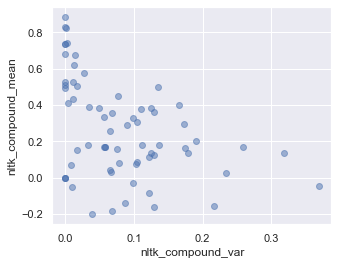

In [68]:
sns.set(rc={'figure.figsize':(5,4)})
fig = plt.scatter(x = 'nltk_compound_var', y = 'nltk_compound_mean', data = class_df.loc[class_df['hazard_type'] == 'bisphenol a'],  alpha=0.5)
plt.xlabel('nltk_compound_var')
plt.ylabel('nltk_compound_mean')

os.makedirs(Path(file_location + 'bpa'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'bpa/plot.png'), bbox_inches="tight")

Seems to be a negative relationship with mean and variance for Bisphenol A: as mean decreases, variance increases: some sentences are still very positive or very negative when mean sentiment is low for the entire post.

In [69]:
pattern_all = ['sentiment','subjectivity','modality_sentence_mean','modality_sentence_var']
nltk_means = ['nltk_neg_mean','nltk_neu_mean', 'nltk_pos_mean', 'nltk_compound_mean' ]  
nltk_vars = ['nltk_neg_var','nltk_neu_var','nltk_pos_var','nltk_compound_var']

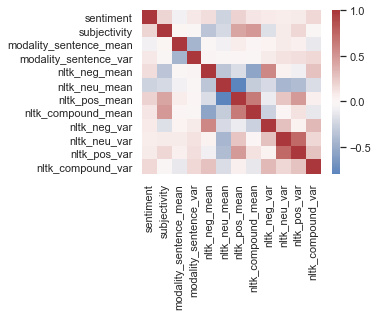

In [70]:
sns.set(rc={'figure.figsize':(4,3)})
fig = sns.heatmap(class_df[pattern_all + nltk_means + nltk_vars].corr(), \
            cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)

os.makedirs(Path(file_location + 'heatmaps'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'heatmaps/sentiments.png'), bbox_inches="tight")

Negative correlations between nltk pos, neu, neg is expected since sum(...) = 1

Correlations with nltk compound reveal the relationship after VADER rules are applied.

Pattern sentiment and ntlk compound are positively correlated which is good, these two scores generally agree.

Subjectivity and Modality are not highly correlated with either, overall. But subjectivity has small (~0.25) negative correlation with neutrality. This is quite intuitive as posts with less strongly indicative words will have more neutral sentiment as well as register a more objective

In [71]:
class_df.loc[np.abs(class_df['sentiment']) < 0.05].loc[class_df['subjectivity'] < 0.05]

infant formula  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 1   
https://www.netmums.com/coffeehouse/coffeehouse... 4                 0   
                                                   26                0   
                                                   29                0   
...                                                                ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108               0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 0   
                                                   6                 0   
                                                   7                 0   
                                                   8                 0   

                                                        sterilized vegetable mixed with fish  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                                      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                       0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                                       0   
                                                   26                                      0   
                                                   29                                      0   
...                                                                                      ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108                                     0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                       0   
                                                   6                                       0   
                                                   7                                       0   
                                                   8                                       0   

                                                        fresh fruit puree mildly processed  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                                    0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                     0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                                     0   
                                                   26                                    0   
                                                   29                                    0   
...                                                                                    ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108                                   0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                     0   
                                                   6                                     0   
                                                   7                                     0   
                                                   8                                     0   

                                                        infant cereals  other  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                0      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 1      0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                 0      0   
                                                   26                0      0   
                                                   29                0      0   
...                                                                ...    ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108               0      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 0      0   
                                                   6                 0      0   
                                                   7                 0     

In [72]:
num_lower_sentiment = len(class_df.loc[class_df['sentiment'] < 0.1])
num_higher_sentiment = len(class_df.loc[class_df['sentiment'] >= 0.1])
print((num_lower_sentiment, num_higher_sentiment))

num_lower_subj = len(class_df.loc[class_df['subjectivity'] < 0.05])
num_higher_subj = len(class_df.loc[class_df['subjectivity'] >= 0.05])
print((num_lower_subj, num_higher_subj))

(1792, 17879)
(7432, 12239)


In [73]:
#TODO: save two lists of keys num_lower_subj, num_higher_subj

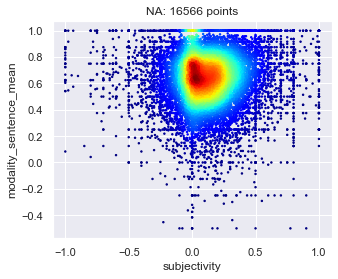

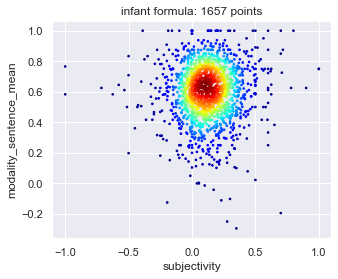

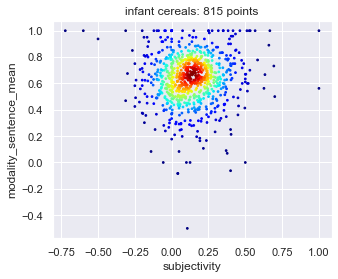

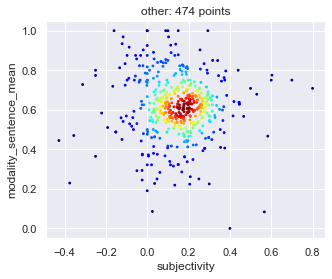

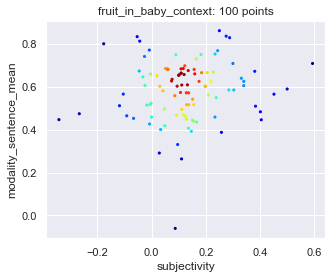

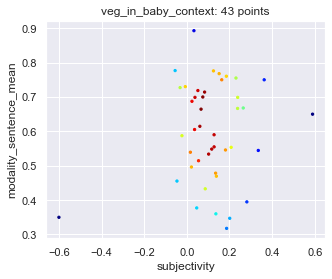

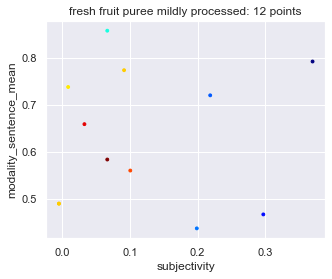

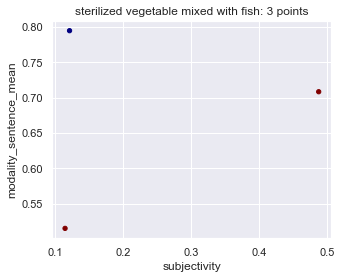

<ipython-input-74-0187a1e9abbf>:6: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


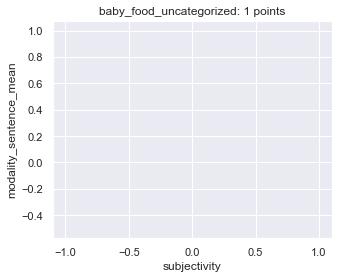

In [74]:
sns.set(rc={'figure.figsize':(5,4)})
errs = []
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    try:
        num_of_posts = class_df.loc[class_df.product_type == category]
        size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
        heat_scatter(num_of_posts, 'modality_sentence_mean','subjectivity', point_size=size_for_cat)
        plt.title(category + ': %s points' % len(num_of_posts))
        plt.show()
    except ValueError:
        print(category + ': insufficient data')
    except Exception as exc:
        errs.append(category + ' ' + str(exc))
        errs.append(str(traceback.format_exc()))
print('\n'.join(errs))

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


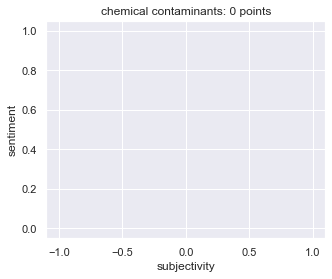

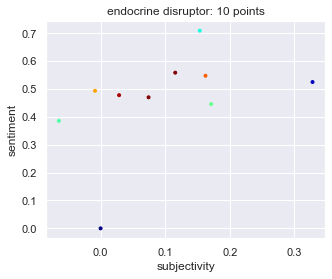

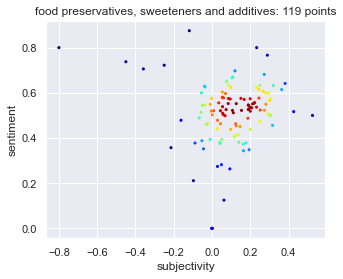

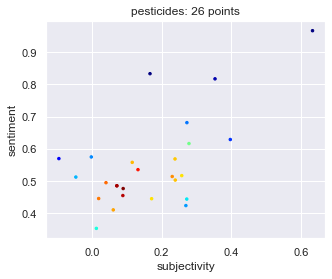

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


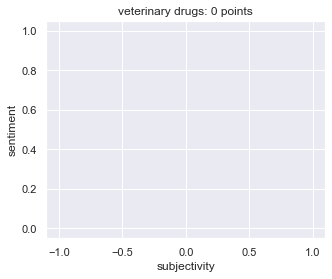

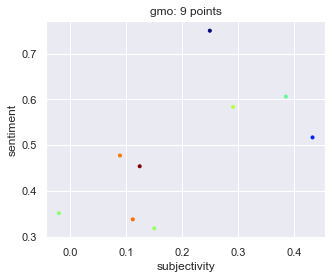

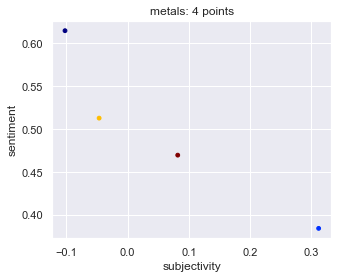

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


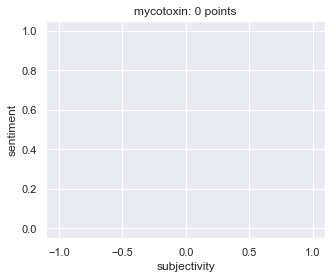

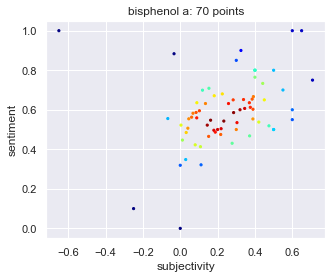

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


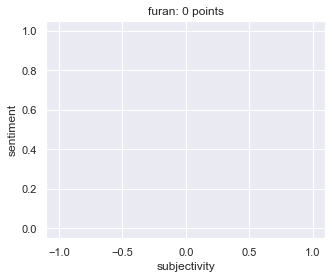

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


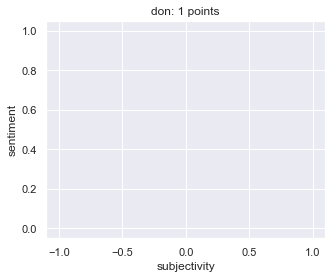

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


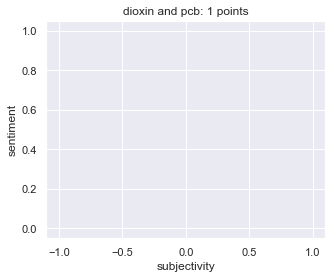

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


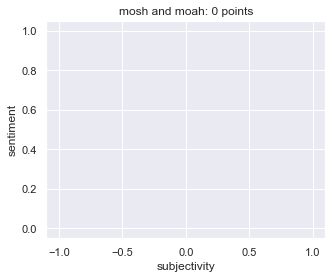

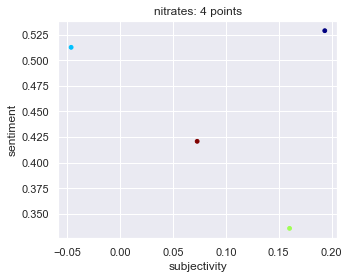

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


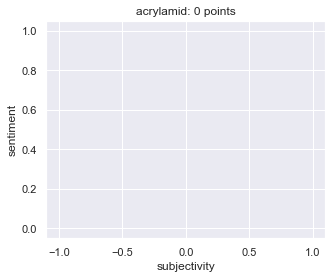

/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:263: RuntimeWarning: divide by zero encountered in true_divide
  result = result / self._norm_factor


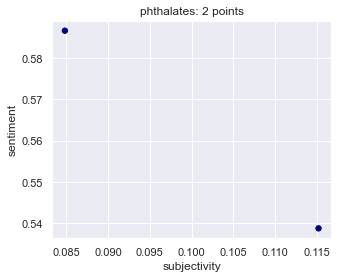

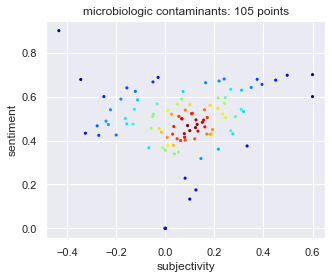

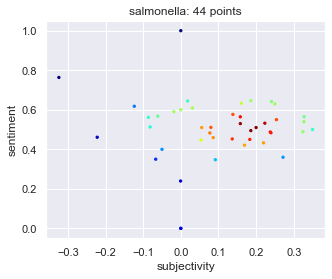

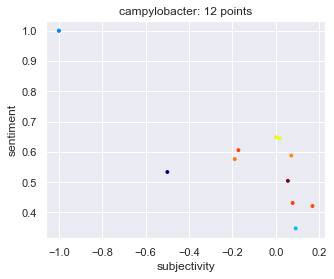

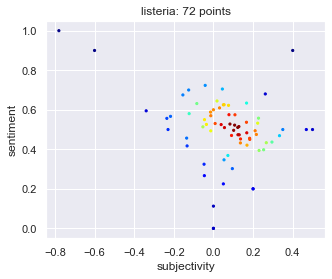

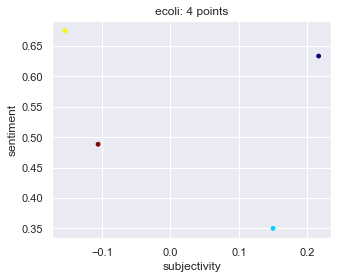

<ipython-input-75-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


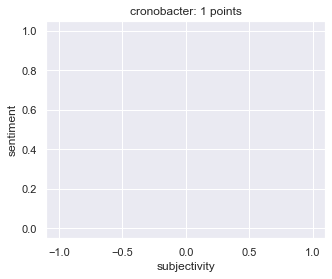

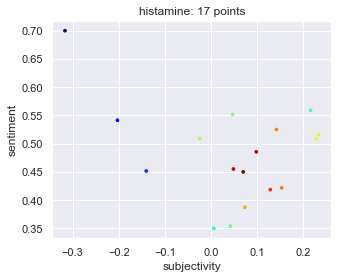

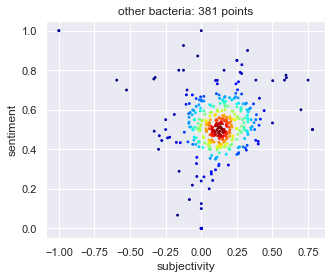

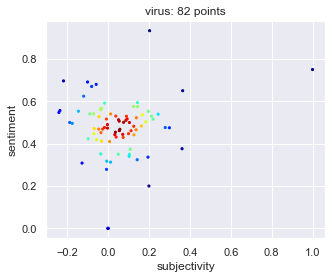

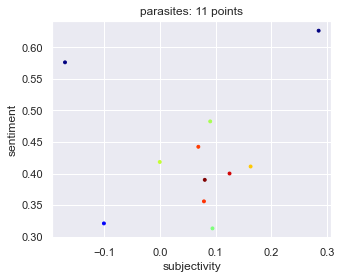

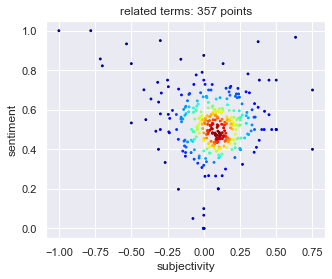

In [75]:
errs = []
for haz in hazards.keys():
    posts_for_hazard = class_df.loc[(class_df[haz] > 0)]
    try:
        size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
        heat_scatter(posts_for_hazard, 'sentiment','subjectivity', point_size=size_for_cat)
        plt.title(haz + ': %s points' % len(posts_for_hazard))
        plt.show()
    except ValueError:
        print(haz + ': insufficient data')
    except Exception as exc:
        errs.append(haz + ' ' + str(exc))
        errs.append(str(traceback.format_exc()))
print('\n'.join(errs))

# Sentiment (Pos/Neg) by Product

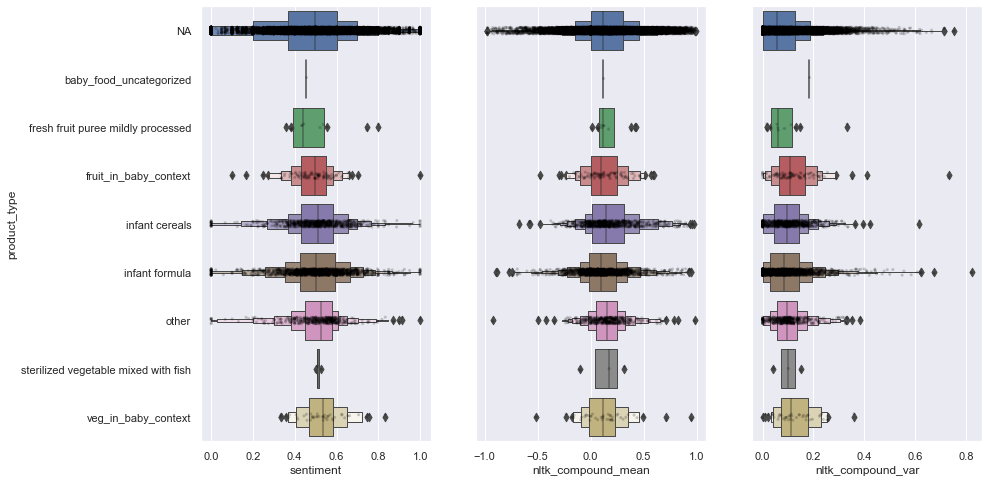

In [76]:
f, axes = plt.subplots(1, 3, figsize=(14,8))

sns.set(rc={'figure.figsize':(5,8)})
g1 = sns.boxenplot(x='sentiment', y='product_type', data=class_df, k_depth = 'trustworthy' , ax = axes[0]) #most are sizes are quite large so it doesnt hurt to use this.
g1 = sns.stripplot(x='sentiment', y='product_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3, ax = axes[0]) #to give an idea of the sample size
#plt.show()
g2 = sns.boxenplot(x='nltk_compound_mean', y='product_type', data=class_df, k_depth = 'trustworthy', ax = axes[1]) #most are sizes are quite large so it doesnt hurt to use this.
g2 = sns.stripplot(x='nltk_compound_mean', y='product_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3, ax = axes[1]) #to give an idea of the sample size
g2.set(yticklabels=[])
g2.set(ylabel=None)
#plt.show()
g2 = sns.boxenplot(x='nltk_compound_var', y='product_type', data=class_df, k_depth = 'trustworthy', ax = axes[2]) #most are sizes are quite large so it doesnt hurt to use this.
g2 = sns.stripplot(x='nltk_compound_var', y='product_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3, ax = axes[2]) #to give an idea of the sample size
g2.set(yticklabels=[])
g2.set(ylabel=None)
plt.show()

#boxplot outlier detection:
#using a method that is a function of the inter-quartile range.
#https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot

# T-Test, F-Test & Boxplots

## Explanations & Setup Code

### Boxplots with NA as baseline
* note that NA / non-classified posts are going to exhibit their own biases
    * general tone of posts on netmums (polite, cordial, friendyl, casual) 
    * these posts are in threads which mention at least one post with a hazard & a product in it (possible negative bias?)

## T-Test & F-Test by Hazard

### F-Tests:

Let x1, x2, . . . , xn and y1, y2, . . . , ym be independent random samples from normal distributions with means μX and μY and standard deviations σX and σY , respectively.

a. To test H0: $σ_X^2 = σ_Y^2$ versus H1: $σ_X^2 > σ_Y^2$ at the α level of significance, reject H0 if $s_Y^2/s_X^2 \leq F_{α,m−1,n−1} $.


b. To test H0: $σ_X^2 = σ_Y^2$ versus H1: $σ_X^2 < σ_Y^2$ at the α level of significance, reject H0 if
$s_Y^2/s_X^2 \geq F_{1−α,m−1,n−1} $.

c. To test H0: $σ_X^2 = σ_Y^2$ versus H1: $σ_X^2 ̸= σ_Y^2$ at the α level of significance, reject H0 if
$s_Y^2 /s_X^2$ is either 

* $\leq F_{α/2,m−1,n−1}$
* $\geq F_{1−α/2,m−1,n−1} $.

alternate version of c: we instead take max of sY/sX or sX/sY, and then check that its <= F_

In [77]:
import scipy

In [78]:
hazard_classes = list(class_df['hazard_type'].value_counts().index.drop('NA'))

In [79]:
baseline_v = np.var(class_df.loc[class_df['hazard_type'] == "NA"]['sentiment'])

m = len(class_df.loc[class_df['hazard_type'] == "NA"]['sentiment'])
n = {item:len(class_df.loc[class_df['hazard_type'] == item]['sentiment']) \
          for item in hazard_classes}

In [80]:
#Definition of Two-Tail F Test: (H0: variance is equal to baseline)
# var(x) / var(y) where x is the item with the larger variance

#Definition of One-Tail F Test (where H0: variance is = or higher than baseline):
# var(x) / var(y) where x is BASELINE

F_Test = {item:np.var(class_df.loc[class_df['hazard_type'] == item]['sentiment']) \
          for item in hazard_classes}

#One-Sided F-Test
#remove zero-variance elements.
F_Test = {key: baseline_v / item for key, item in F_Test.items() if item > 0}

#Make it Two-Sided
#remove zero-variance elements.
F_Test = {key: max(value, 1./value) for key, value in F_Test.items() if value > 0}

#define rejection level
alpha = 0.05

#Test against the F distirbution at the given level
F_Test = {key:scipy.stats.f.cdf(F, m - 1, n[key]-1) for key, F in F_Test.items()}
F_Test = {key:{'Reject H0':p>1-(alpha/2),'p':p } for key, p in F_Test.items()}

In [81]:
#show results
pd.DataFrame(F_Test).transpose()

,Reject H0,p
other bacteria,True,1
related terms,True,1
"food preservatives, sweeteners and additives",True,1
microbiologic contaminants,True,0.999984
virus,True,0.999998
bisphenol a,True,0.98996
listeria,False,0.973255
salmonella,True,0.97647
pesticides,True,0.984031
histamine,True,0.999934


### Paired T-Test
We exploit threads to do paired t-test for posts mentioning a hazard vs posts NOT mentioning a hazard (matched-pairs sample)

We pair by taking the average senitment for NA posts in a thread vs hazard-cointaining posts within a thread.

Main weakness: if threads are mainly ABOUT that hazard and NA posts just don't mention it specifically by name while still being in the context of it, then the signifance will be __underestimated__. If a hazard is mentioned once, off-topic, in a thread of a different topic then the significance of the result may be __overestimated__.

__To improve on this model it would be good to:__
* __1) Develop a metric to ensure the main topic of a thread (topic mining on titles, variance of term counts in thread..?)__
* __2) Calculate an Independent T-Test where we have a random sampling from all threads vs our selected subset. (however our entire scrape still has its own sample bias, but I do believe the entire thing is a quite noisy sample)__
* __3) Possibly correct specification of degrees of freedom, since these samples are means of other samples which means the sample size is actually larger.__


TODO: independent T-Tests on thread-averages, comparing NA-only threads vs hazard-containing threads. 
I want to select only threads where a hazard is mentioned in the title/more than once/etc but 1) kind of p-hacky and 2) sounds like it will limite data a LOT!

H0: mean_NA = mean_othergroup

H1: mean_NA != mean_othergroup

#### Data Prep

In [82]:
#we are trying to get the threads for which we can run a paired t-test
#we can't use index.levels[0] because that just returns the indexes form the original, not the view.
threads_with_NA = set(list(zip(*list(class_df.loc[class_df['hazard_type'] == 'NA'].index)))[0])
threads_without_NA = set(list(zip(*list(class_df.loc[class_df['hazard_type'] != 'NA'].index)))[0])
print(len(threads_without_NA - threads_with_NA), len(threads_with_NA - threads_without_NA))

0 61


^ from above, we know that ALL threads have NA classed posts. But not all threads have well-classified posts.
For the paired T-Test we will just use the threads which contain non-NA posts.

note that in total there are 510 unique threads. and now we will drop 61 of them.

In [83]:
paired_df = class_df.loc[threads_without_NA.intersection(threads_with_NA)].copy() #the df without unneeded threads.

In [84]:
#get means grouped by thread & classification
paired_df = paired_df.reset_index().groupby(by = ['hazard_type', 'level_0']).mean().dropna()
paired_df = paired_df.reset_index().set_index('level_0')

In [85]:
#PRODUCT VERSION UGH

#we are trying to get the threads for which we can run a paired t-test
#we can't use index.levels[0] because that just returns the indexes form the original, not the view.
prod_threads_with_NA = set(list(zip(*list(class_df.loc[class_df['product_type'] == 'NA'].index)))[0])
prod_threads_without_NA = set(list(zip(*list(class_df.loc[class_df['product_type'] != 'NA'].index)))[0])
print(len(prod_threads_without_NA - prod_threads_with_NA), len(prod_threads_with_NA - prod_threads_without_NA))

prod_paired_df = class_df.loc[prod_threads_without_NA.intersection(prod_threads_with_NA)].copy() #the df without unneeded threads.

#get means grouped by thread & classification
prod_paired_df = prod_paired_df.reset_index().groupby(by = ['product_type', 'level_0']).mean().dropna()
prod_paired_df = prod_paired_df.reset_index().set_index('level_0')

5 107


In [86]:
#create a dict of paired values for plotting. 
#This needs to be created only once (as long as all relevant variables have been added to dataframe)

#structure of dict:
#{term: (dataframe of values from term with thread as index, dataframe of values of NA with the same index)
#term:...
#}

paired_values = {}
for label in paired_df['hazard_type'].value_counts().index.drop('NA'): # for label in list of labels except NA
    relevant_index = paired_df.loc[paired_df['hazard_type'] == label].index
    # get the index of all rows for certain label
    # this is used in the next line because this index is NOT unique.
    # MULTIPLE ROWS HAVE THE SAME INDEX VALUE (thread url)
    paired_values[label] = (paired_df.loc[paired_df['hazard_type'] == label], \
                           paired_df.loc[paired_df['hazard_type'] == 'NA'].loc[relevant_index])
   

prod_paired_values = {} #it works fine despite being red. its just a glitch in jupyter.

for label in prod_paired_df['product_type'].value_counts().index.drop('NA'):
    relevant_index = prod_paired_df.loc[prod_paired_df['product_type'] == label].index
    prod_paired_values[label] = (prod_paired_df.loc[prod_paired_df['product_type'] == label], \
                           prod_paired_df.loc[prod_paired_df['product_type'] == 'NA'].loc[relevant_index])

In [87]:
{key:len(i[0]) for key, i in prod_paired_values.items()}

{'infant formula': 268,
 'infant cereals': 167,
 'other': 109,
 'fruit_in_baby_context': 55,
 'veg_in_baby_context': 27,
 'fresh fruit puree mildly processed': 11,
 'sterilized vegetable mixed with fish': 2,
 'baby_food_uncategorized': 1}

In [88]:
{key:len(i[0]) for key, i in paired_values.items()}

{'related terms': 167,
 'other bacteria': 161,
 'food preservatives, sweeteners and additives': 64,
 'microbiologic contaminants': 48,
 'virus': 44,
 'listeria': 33,
 'salmonella': 23,
 'pesticides': 16,
 'histamine': 13,
 'parasites': 8,
 'gmo': 7,
 'endocrine disruptor': 7,
 'campylobacter': 6,
 'bisphenol a': 6,
 'metals': 3,
 'ecoli': 3,
 'nitrates': 2,
 'phthalates': 1,
 'don': 1,
 'cronobacter': 1}

In [148]:
##define a function which is useful for making nice box plots
#points are displayed to make viewer more aware of small sample sizes

def boxstrip(x_name:str, y_name:str, df=class_df):
    """
    x some continuous or integer data, y some category which contains a cat 'NA'
    """
    sns.boxplot(x=x_name, y=y_name, data=df, fliersize=0, linewidth=1)
    #sns.boxenplot(x='subjectivity', y='hazard_type', data=class_df, k_depth='full', showfliers=False)
    sns.stripplot(x=x_name, y=y_name, data=df, color='black', alpha=0.8, jitter=0.07, size=3)
    #vertical line at 50% quantile of NA, as a baseline
    return plt.axvline(np.nanquantile(class_df.loc[df[y_name] == 'NA'][x_name],0.5), 0, c='red', linewidth=1)

## PRODUCT BOX PLOTS

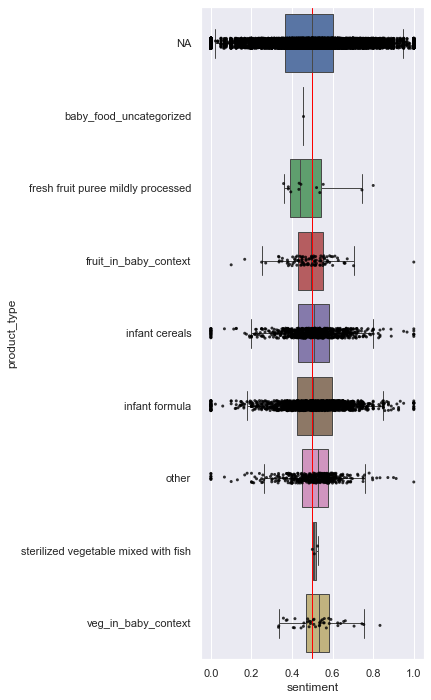

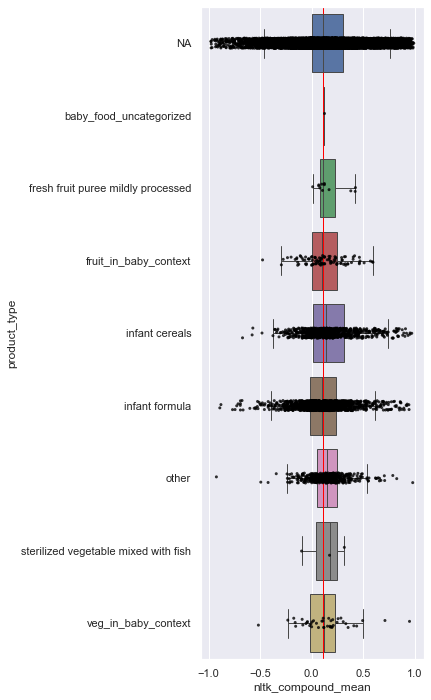

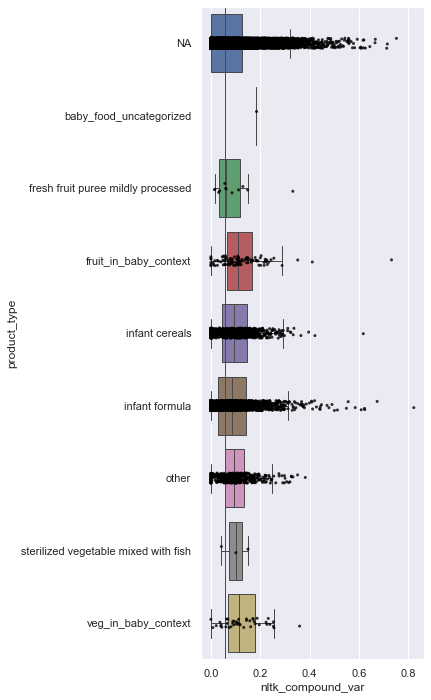

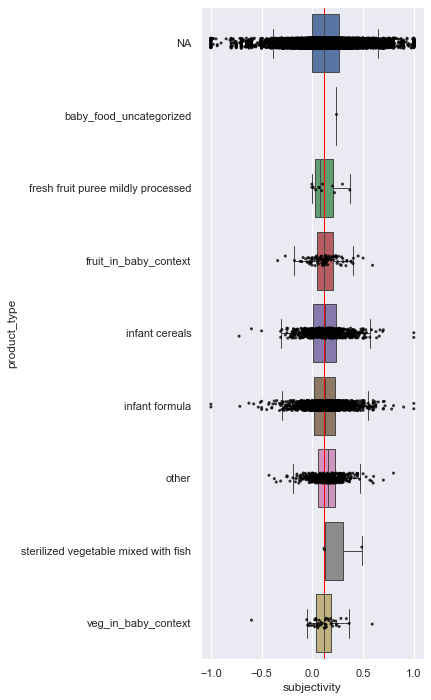

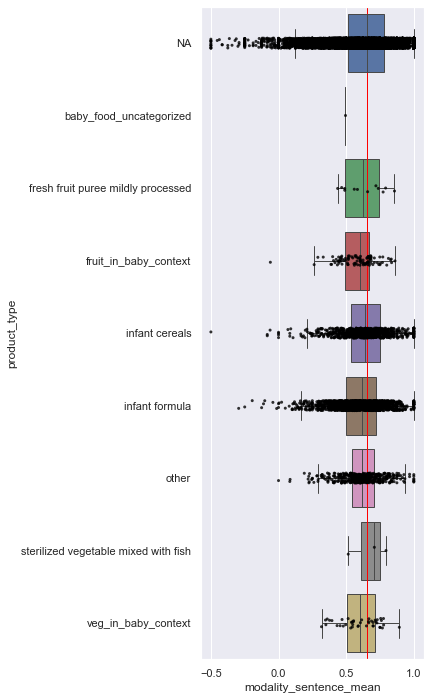

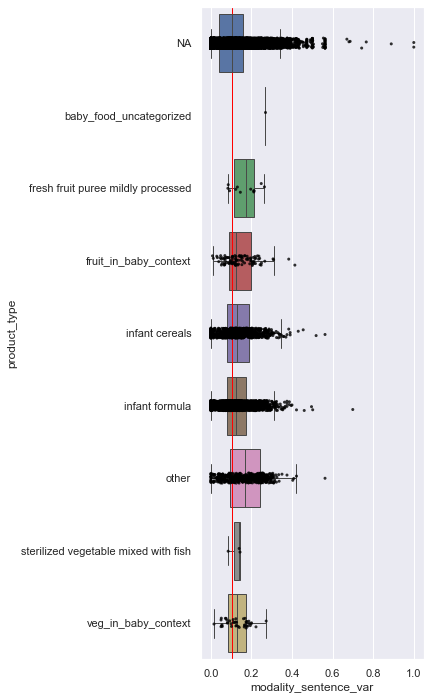

In [149]:
#generate all boxplots
sns.set(rc={'figure.figsize':(4,12)})
os.makedirs(Path(file_location + 'product_box_plots'), exist_ok=True)

fig = boxstrip('sentiment', 'product_type')
plt.show()
fig.figure.savefig(Path(file_location + 'product_box_plots/pat_prod_box.png'), bbox_inches="tight")

fig = boxstrip('nltk_compound_mean', 'product_type')
plt.show()
nltk_prod_box = fig.figure.savefig(Path(file_location + 'product_box_plots/pat_prod_box.png'), bbox_inches="tight")

fig = boxstrip('nltk_compound_var', 'product_type')
plt.show()
fig.figure.savefig(Path(file_location + 'product_box_plots/nltk_var_prod_box.png'), bbox_inches="tight")

fig = boxstrip('subjectivity', 'product_type')
plt.show()
fig.figure.savefig(Path(file_location + 'product_box_plots/subj_prod_box.png'), bbox_inches="tight")

fig = boxstrip('modality_sentence_mean','product_type')
plt.show()
fig.figure.savefig(Path(file_location + 'product_box_plots/mod_prod_box.png'), bbox_inches="tight")

fig = boxstrip('modality_sentence_var','product_type')
plt.show()
fig.figure.savefig(Path(file_location + 'product_box_plots/mod_var_prod_box.png'), bbox_inches="tight")

#os.makedirs(Path(file_location + 'heatmaps'), exist_ok=True)
#fig.figure.savefig(Path(file_location + 'heatmaps/test.png'))


## Sentiment (Pos/Neg) by Hazard

It may seem strange that these terms have positive sentiment. Keep in mind that we are looking at the sentiment in the entire post where the term occurs, and people are netmums are quite often very friendly to each other when replying.

#TODO: use only subset of terms around the phrases! (non-per  post approach probablY)

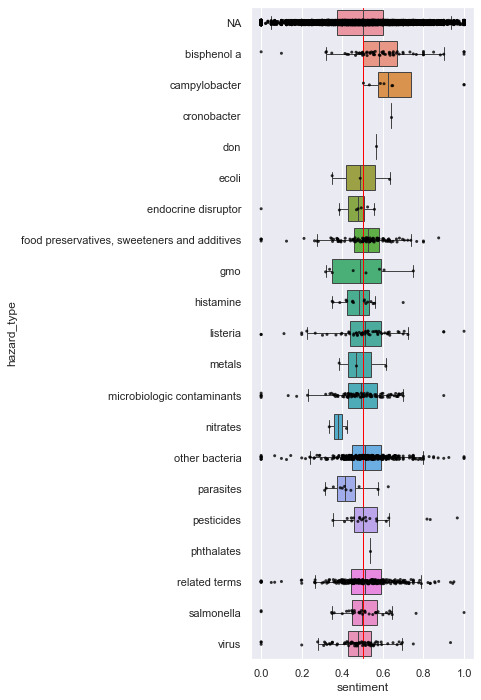

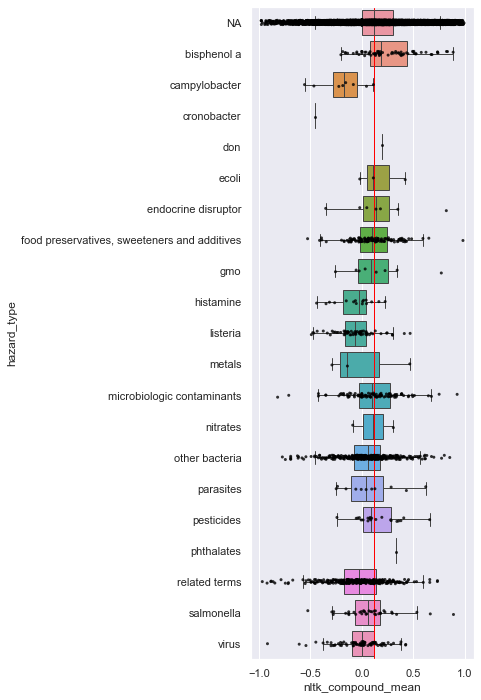

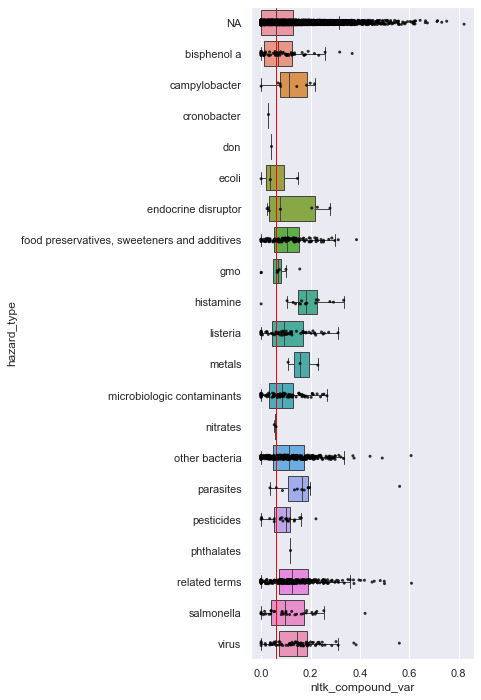

In [150]:
#sns.set(rc={'figure.figsize':(4,12)})
#sns.boxenplot(x='sentiment', y='hazard_type', data=class_df)
#plt.show()
#sns.boxenplot(x='nltk_compound_mean', y='hazard_type', data=class_df)
#plt.show()

sns.set(rc={'figure.figsize':(4,12)})
fig = boxstrip('sentiment', 'hazard_type')
plt.show()

os.makedirs(Path(file_location + 'hazard_box_plots'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'hazard_box_plots/pat_haz_box.png'), bbox_inches="tight")

#
fig = boxstrip('nltk_compound_mean', 'hazard_type')
plt.show()

os.makedirs(Path(file_location + 'hazard_box_plots'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'hazard_box_plots/nltk_haz_box.png'), bbox_inches="tight")
#

fig =boxstrip('nltk_compound_var', 'hazard_type')
plt.show()

os.makedirs(Path(file_location + 'hazard_box_plots'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'hazard_box_plots/nltk_var_haz_box.png'), bbox_inches="tight")



### Pattern Sent: T-Test & F-Test by Hazard

#### Check if normally distributed (visual check)

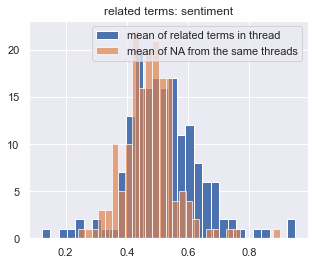

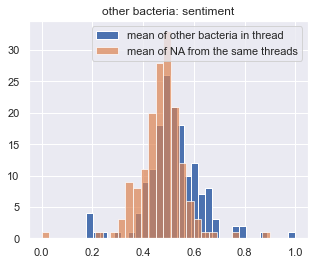

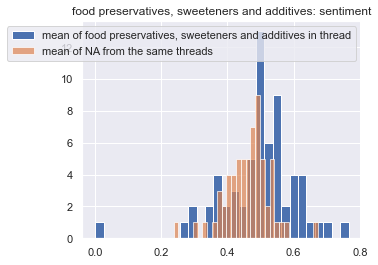

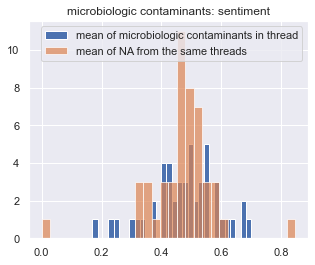

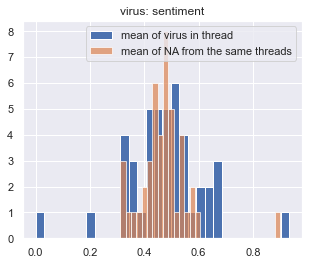

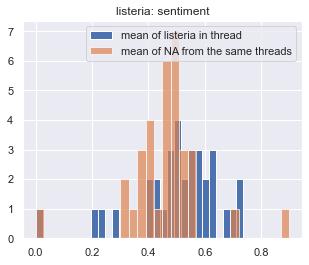

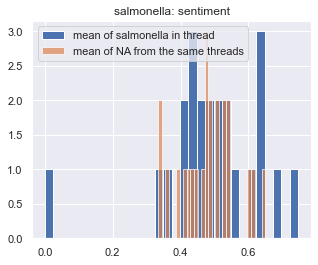

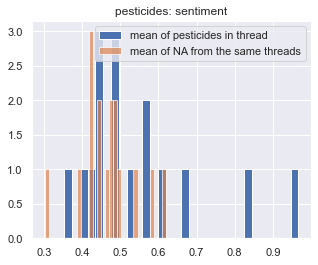

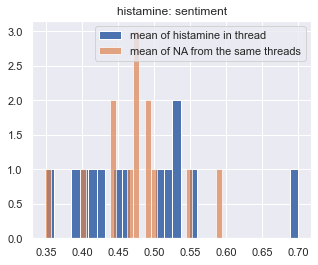

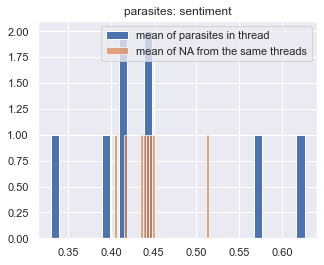

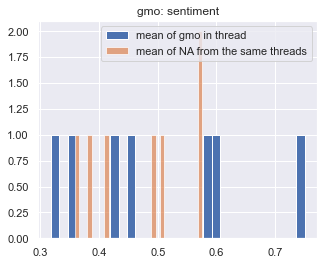

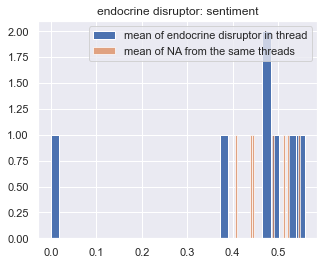

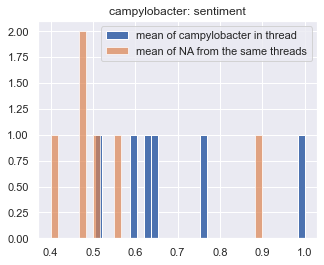

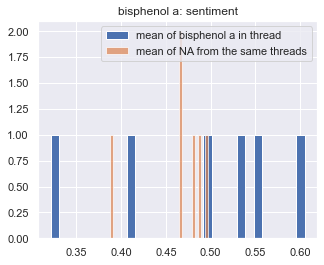

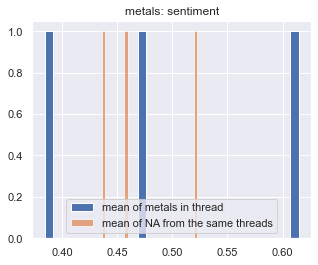

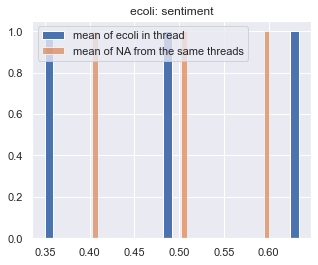

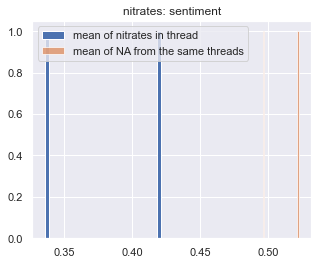

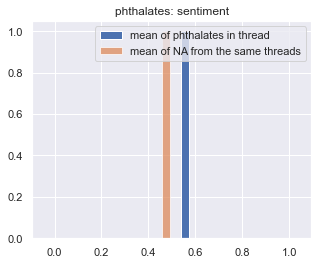

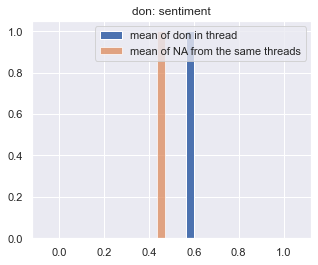

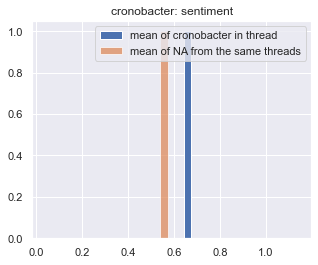

In [151]:
#check that the data are normally distributed
sns.set(rc={'figure.figsize':(5,4)})
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    plt.hist(paired_values[label][0]['sentiment'], bins=30)
    plt.hist(paired_values[label][1]['sentiment'], bins = 30, alpha=0.7)
    plt.title('%s: sentiment' % label)
    plt.legend(['mean of %s in thread' % label ,'mean of NA from the same threads'])
    plt.show()

For larger sample sizes our data looks roughly normally distributed. It is then reasonable to assume with this prior knowledge that the other terms should also follow a normal distribution.

In [152]:
#Paired and Independent T-Test.
#Independent T-Test (assumes independence...)
#TODO: for this one I want to get some data from OTHER threads, as it will be more independent.
baseline_mean = None #TODO Independent T-Test

#Paired
def get_paired_t_tests(paired_data:dict, col:str, perm=None):
    """ get paired t tests for NA vs type
    data is a dict of dataframes as seen above, same structure.
    col is the column to grab form the dataframes
    """

    testit = scipy.stats.ttest_rel #maybe run a tad faster, lol..
    return {key: testit(value[0][col], value[1][col]) for key, value in paired_data.items()}

#Style-Related Functions

def highlight_signif_rows(s, props=''):
    """
    function for use with pandas styler. if a cell contains True then the entire row/column will be made green
    """
    #only works with axis specified as 1 or 0 
    check = np.where(s == True, True, False)
    if True in check:
        return np.repeat(props,len(s))
    else:
        return np.repeat('', len(s))
    
    
def display_t_test(highlight = True):
    """
    needs global vars T_Test:df and alpha:str to exist.
    """
    display_df = pd.DataFrame(T_Test).transpose().rename({0:'T-Statistic',1:'p-value (two-sided)'}, axis=1)
    colname = 'Reject H0 (two sided) at alpha %s' % alpha
    display_df[colname] = display_df['p-value (two-sided)'] < alpha
    if highlight:
        return display_df.style.apply(highlight_signif_rows, props='background-color:lightgreen', axis=1)
    else:
        return display_df

In [203]:
T_Test = get_paired_t_tests(paired_values, 'sentiment')

os.makedirs(Path(file_location + 'ttest'), exist_ok=True)
with open(Path(file_location + 'ttest/pattern.html'), 'w') as f:
        f.write(display_t_test(T_Test).render())

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### NLTK Sent: T-Test & F-Test by Hazard

#### Check if normally distributed (visual check)

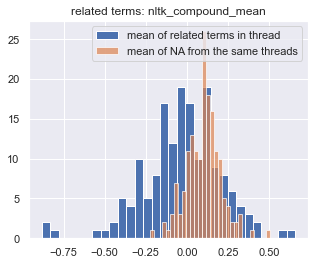

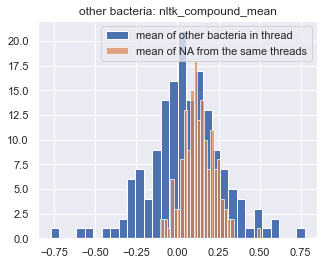

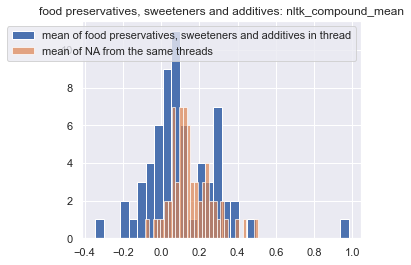

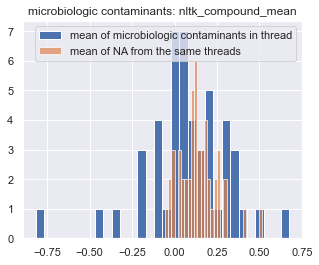

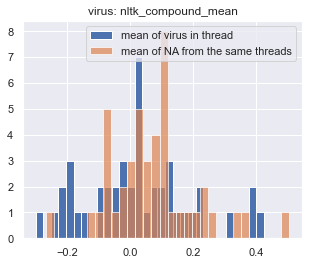

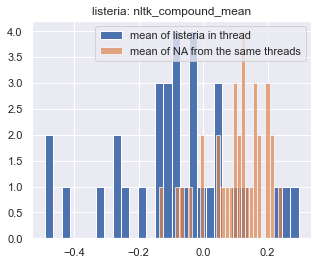

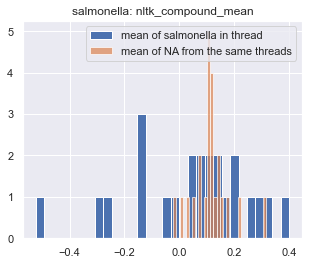

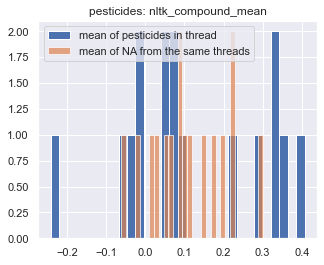

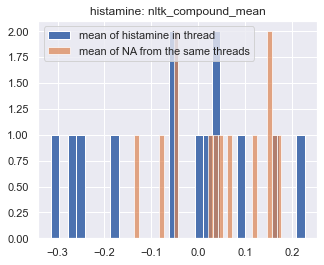

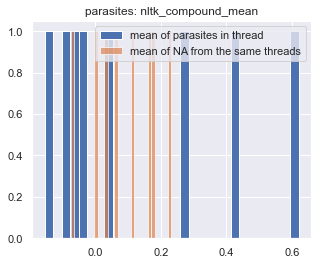

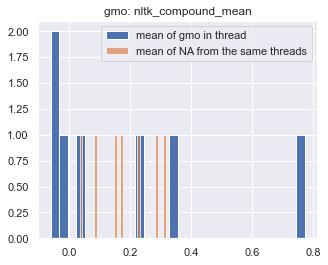

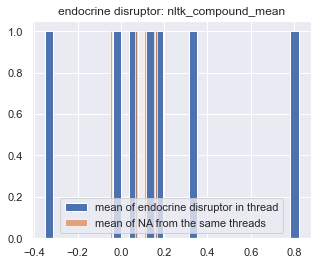

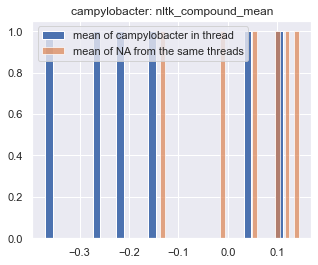

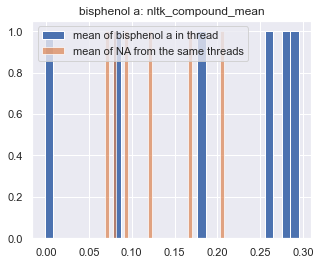

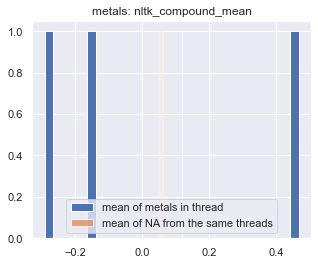

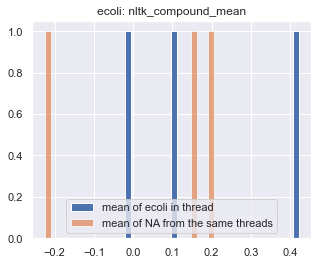

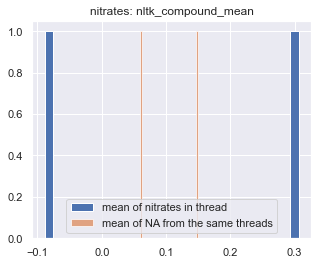

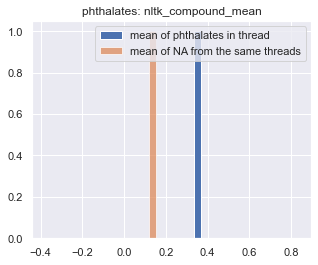

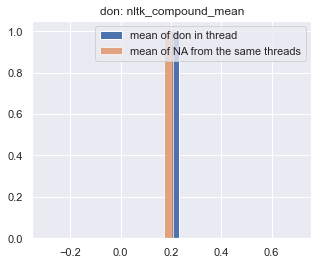

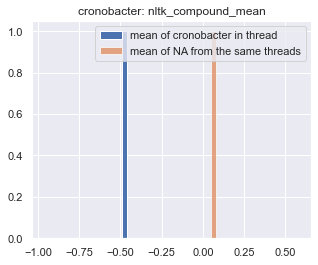

In [154]:
#check that the data are normally distributed
sns.set(rc={'figure.figsize':(5,4)})
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    plt.hist(paired_values[label][0]['nltk_compound_mean'], bins=30)
    plt.hist(paired_values[label][1]['nltk_compound_mean'], bins = 30, alpha=0.7)
    plt.title('%s: nltk_compound_mean' % label)
    plt.legend(['mean of %s in thread' % label ,'mean of NA from the same threads'])
    plt.show()

#### F Test

In [155]:
F_Test = {item:np.var(class_df.loc[class_df['hazard_type'] == item]['nltk_compound_mean']) \
          for item in hazard_classes}

#One-Sided F-Test
#remove zero-variance elements.
F_Test = {key: baseline_v / item for key, item in F_Test.items() if item > 0}

#Make it Two-Sided
#remove zero-variance elements.
F_Test = {key: max(value, 1./value) for key, value in F_Test.items() if value > 0}

#define rejection level
confidence_level = 0.95
alpha = 0.05

#Test against the F distirbution at the given level
F_Test = {key:scipy.stats.f.cdf(F, m - 1, n[key]-1) for key, F in F_Test.items()}
F_Test = {key:{'Reject H0':p>1-(alpha/2),'p':p } for key, p in F_Test.items()}

In [156]:
#show results
pd.DataFrame(F_Test).transpose()

,Reject H0,p
other bacteria,True,0.999988
related terms,True,1
"food preservatives, sweeteners and additives",False,0.485118
microbiologic contaminants,True,0.992869
virus,False,0.559407
bisphenol a,True,0.976483
listeria,False,0.850894
salmonella,False,0.883518
pesticides,False,0.716678
histamine,False,0.813741


#### Paired T-Test

In [157]:
T_Test = get_paired_t_tests(paired_values, 'nltk_compound_mean')

os.makedirs(Path(file_location + 'ttest'), exist_ok=True)
with open(Path(file_location + 'ttest/nltk.html'), 'w') as f:
        f.write(display_t_test(T_Test).render())

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Subjectivity

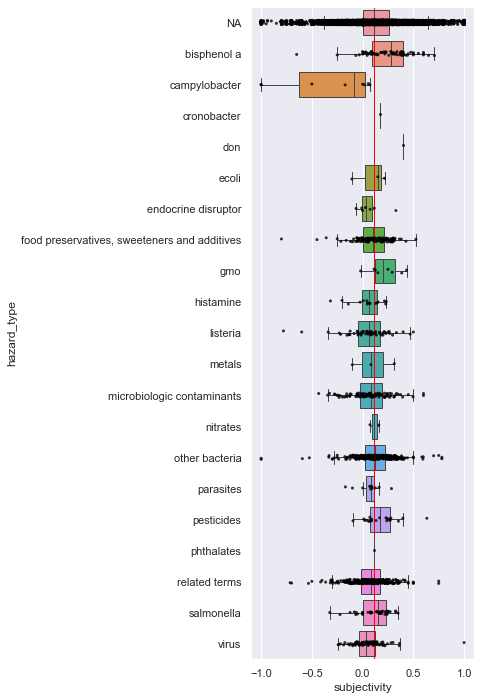

In [158]:
sns.set(rc={'figure.figsize':(4,12)})
fig = boxstrip('subjectivity', 'hazard_type')
plt.show()

os.makedirs(Path(file_location + 'hazard_box_plots'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'hazard_box_plots/subj_haz_box.png'), bbox_inches="tight")



TODO: write comments about this

### Subjectivity: T-Test & F-Test by Hazard

#### Check if normally distributed (visual check)

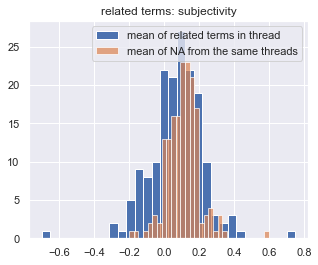

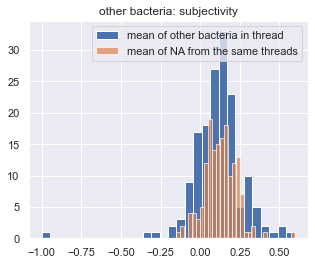

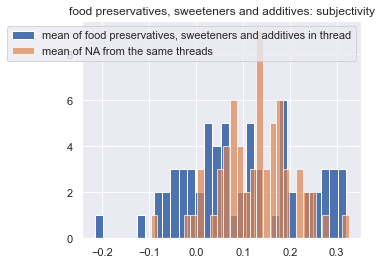

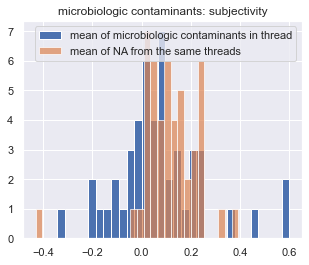

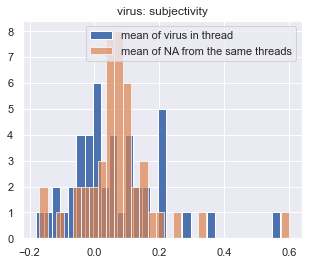

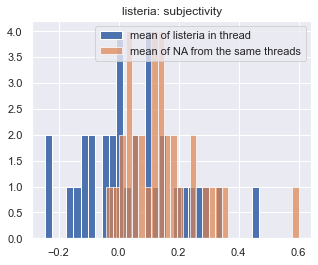

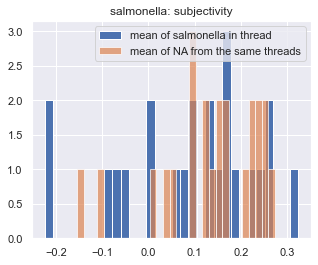

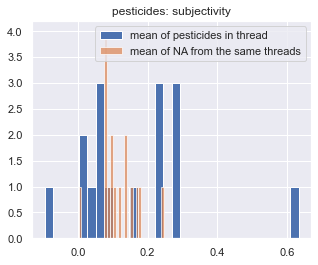

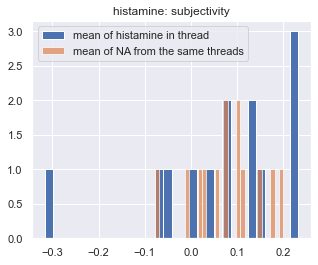

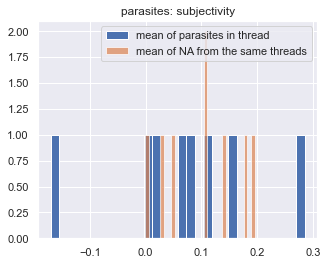

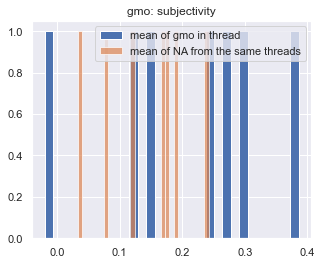

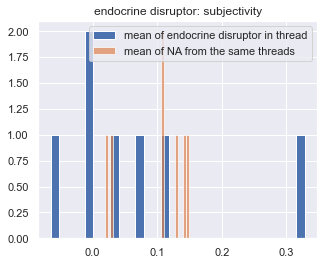

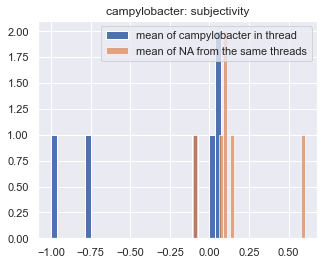

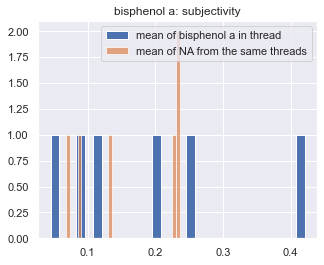

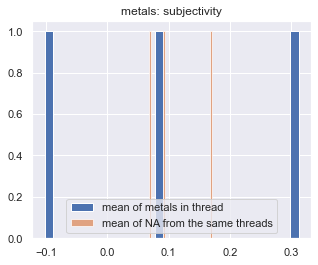

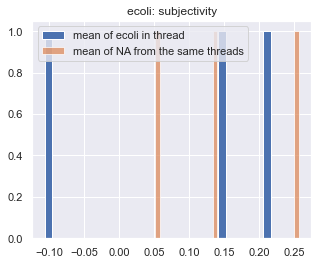

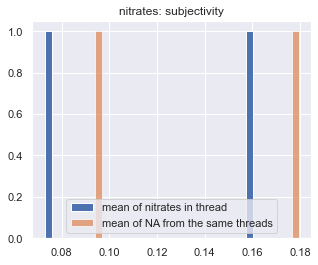

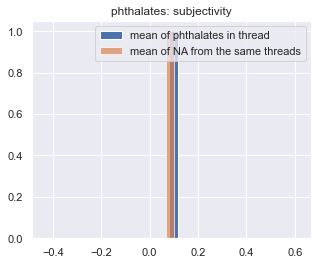

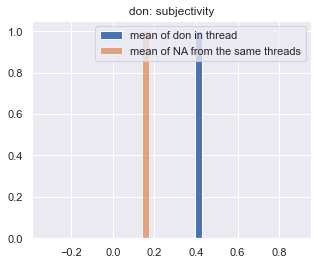

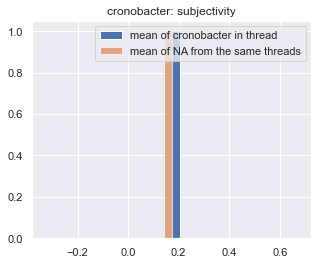

In [159]:
#check that the data are normally distributed
sns.set(rc={'figure.figsize':(5,4)})
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    plt.hist(paired_values[label][0]['subjectivity'], bins=30)
    plt.hist(paired_values[label][1]['subjectivity'], bins = 30, alpha=0.7)
    plt.title('%s: subjectivity' % label)
    plt.legend(['mean of %s in thread' % label ,'mean of NA from the same threads'])
    plt.show()

#### F Test

In [160]:
F_Test = {item:np.var(class_df.loc[class_df['hazard_type'] == item]['subjectivity']) \
          for item in hazard_classes}

#One-Sided F-Test
#remove zero-variance elements.
F_Test = {key: baseline_v / item for key, item in F_Test.items() if item > 0}

#Make it Two-Sided
#remove zero-variance elements.
F_Test = {key: max(value, 1./value) for key, value in F_Test.items() if value > 0}

#define rejection level
alpha = 0.05

#Test against the F distirbution at the given level
F_Test = {key:scipy.stats.f.cdf(F, m - 1, n[key]-1) for key, F in F_Test.items()}
F_Test = {key:{'Reject H0':p>1-(alpha/2),'p':p } for key, p in F_Test.items()}

In [161]:
#show results
pd.DataFrame(F_Test).transpose()

,Reject H0,p
other bacteria,True,0.999884
related terms,True,0.999934
"food preservatives, sweeteners and additives",True,0.999541
microbiologic contaminants,False,0.966179
virus,True,0.999378
bisphenol a,False,0.510658
listeria,False,0.667607
salmonella,True,0.995883
pesticides,False,0.964468
histamine,False,0.962223


#### Paired T-Test

In [162]:
display_t_test(T_Test).render()

'<style  type="text/css" >\n#T_f570b4dc_155a_11ec_be9a_80e6501f9016row0_col0,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row0_col1,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row0_col2,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row1_col0,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row1_col1,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row1_col2,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row5_col0,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row5_col1,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row5_col2,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row12_col0,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row12_col1,#T_f570b4dc_155a_11ec_be9a_80e6501f9016row12_col2{\n            background-color: lightgreen;\n        }</style><table id="T_f570b4dc_155a_11ec_be9a_80e6501f9016" ><thead>    <tr>        <th class="blank level0" ></th>        <th class="col_heading level0 col0" >T-Statistic</th>        <th class="col_heading level0 col1" >p-value (two-sided)</th>        <th class="col_heading level0 col2" >Reject H0 (two sided) at alpha 0.05</t

In [163]:
T_Test = get_paired_t_tests(paired_values, 'subjectivity')

os.makedirs(Path(file_location + 'ttest'), exist_ok=True)
with open(Path(file_location + 'ttest/subj.html'), 'w') as f:
        f.write(display_t_test(T_Test).render())

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Modality

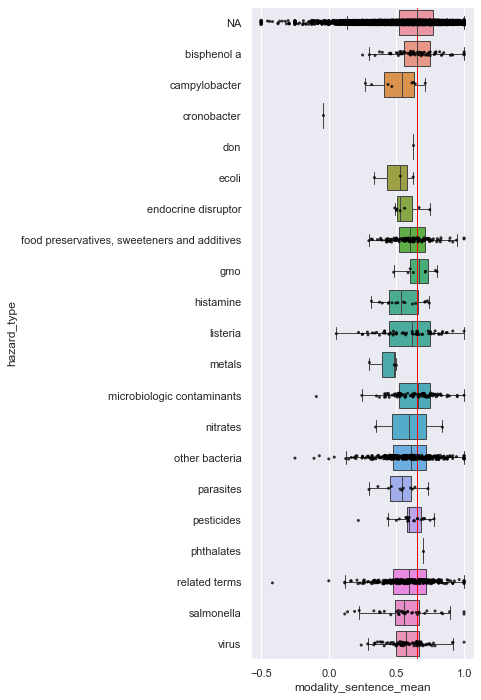

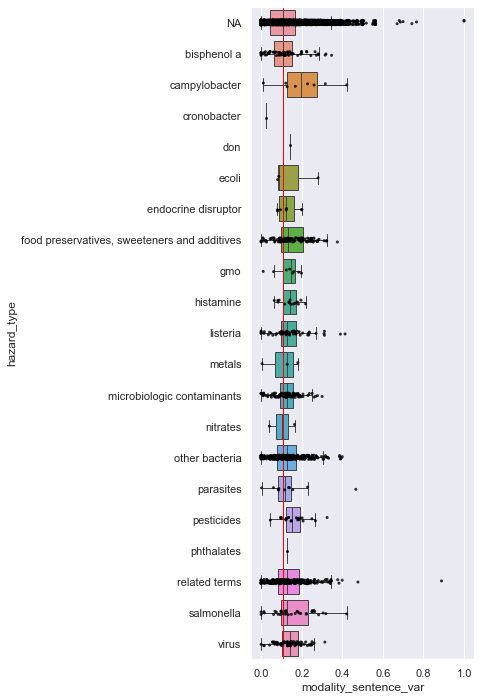

In [164]:
sns.set(rc={'figure.figsize':(4,12)})
boxstrip('modality_sentence_mean','hazard_type')
plt.show()

os.makedirs(Path(file_location + 'hazard_box_plots'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'hazard_box_plots/mod_haz_box.png'), bbox_inches="tight")

boxstrip('modality_sentence_var','hazard_type')
plt.show()

os.makedirs(Path(file_location + 'hazard_box_plots'), exist_ok=True)
fig.figure.savefig(Path(file_location + 'hazard_box_plots/mod_var_haz_box.png'), bbox_inches="tight")

We can see that compared to posts without hazard terms (NA), posts with hazards mentioned tend to have lower confidence in what they are saying.

note: data for DON is extremely small. It is only one observation which by checking manually, I can confirm is not relevant (it is a typo of don't )
Cronobacter is also only one observation.

### Modality: T-Test & F-Test by Hazard

#### Check if normally distributed (visual check)

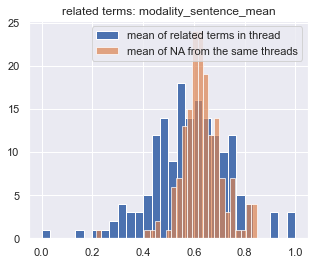

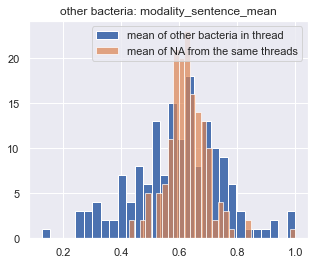

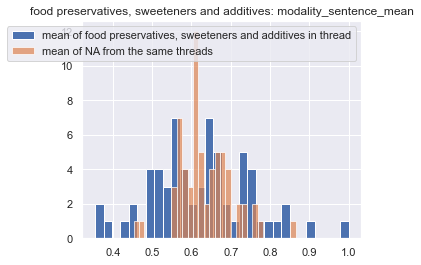

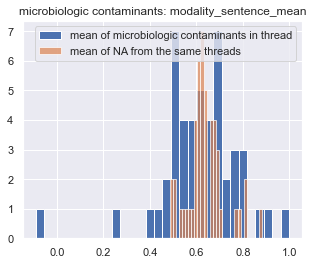

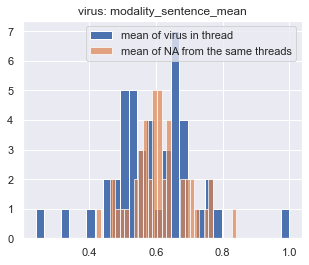

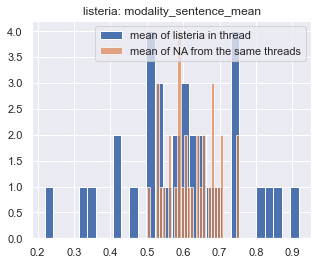

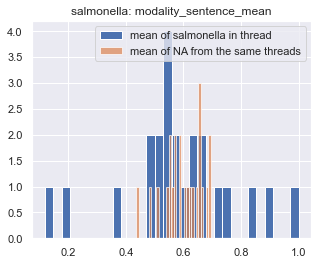

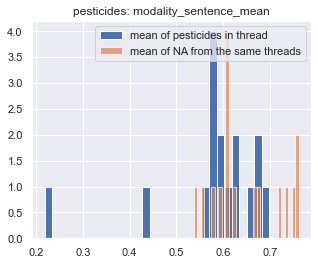

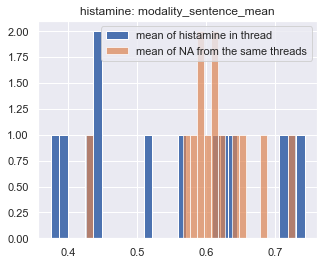

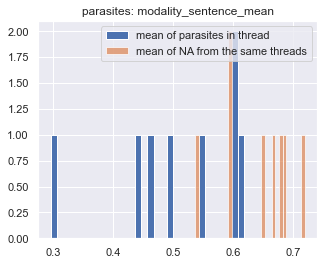

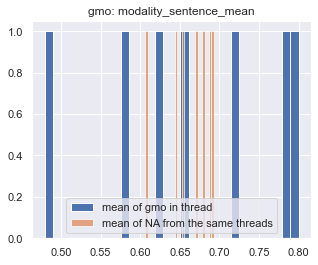

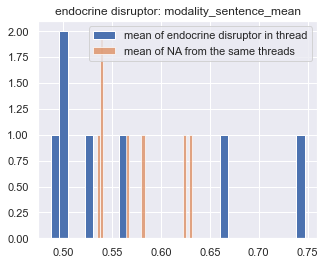

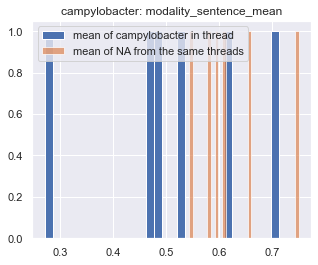

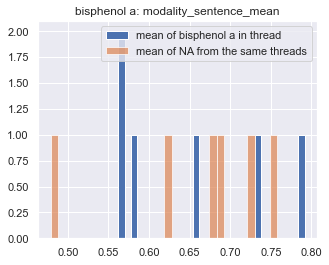

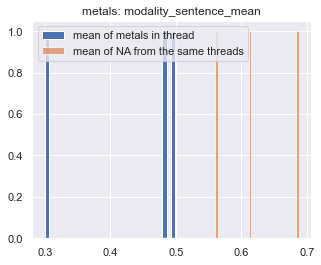

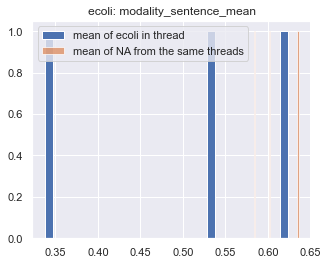

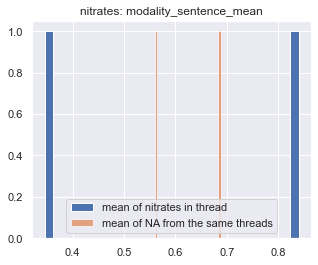

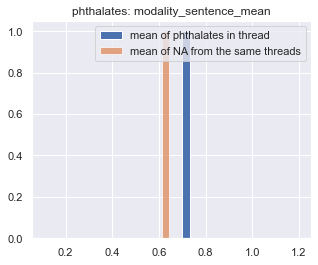

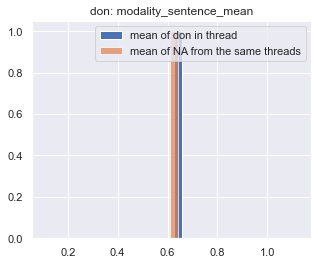

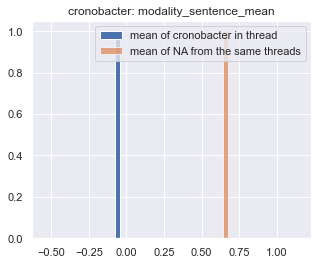

In [165]:
#check that the data are normally distributed
sns.set(rc={'figure.figsize':(5,4)})
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    plt.hist(paired_values[label][0]['modality_sentence_mean'], bins=30)
    plt.hist(paired_values[label][1]['modality_sentence_mean'], bins = 30, alpha=0.7)
    plt.title('%s: modality_sentence_mean' % label)
    plt.legend(['mean of %s in thread' % label ,'mean of NA from the same threads'])
    plt.show()

#### F Test

In [166]:
F_Test = {item:np.var(class_df.loc[class_df['hazard_type'] == item]['modality_sentence_mean']) \
          for item in hazard_classes}

#One-Sided F-Test
#remove zero-variance elements.
F_Test = {key: baseline_v / item for key, item in F_Test.items() if item > 0}

#Make it Two-Sided
#remove zero-variance elements.
F_Test = {key: max(value, 1./value) for key, value in F_Test.items() if value > 0}

#define rejection level
alpha = 0.05

#Test against the F distirbution at the given level
F_Test = {key:scipy.stats.f.cdf(F, m - 1, n[key]-1) for key, F in F_Test.items()}
F_Test = {key:{'Reject H0':p>1-(alpha/2),'p':p } for key, p in F_Test.items()}

In [167]:
#show results
pd.DataFrame(F_Test).transpose()

,Reject H0,p
other bacteria,True,0.999911
related terms,True,0.999965
"food preservatives, sweeteners and additives",True,1
microbiologic contaminants,True,0.999977
virus,True,1
bisphenol a,True,0.999283
listeria,False,0.875511
salmonella,False,0.658293
pesticides,True,0.999347
histamine,True,0.989631


#### Paired T-Test

In [168]:
T_Test = get_paired_t_tests(paired_values, 'modality_sentence_mean')

os.makedirs(Path(file_location + 'ttest'), exist_ok=True)
with open(Path(file_location + 'ttest/modality.html'), 'w') as f:
        f.write(display_t_test(T_Test).render())

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Number of Occurences of Hazard Term by Category

Here, we examine the number of occurences in a post, with the goal of performing regressions between our metrics and the number of occurences in a post. Of course, if the number of occurences does not vary much then the regressions will be pointless

In [169]:
#assign the max to it's own col to graph easily
class_df['count_for_classified_hazard'] =class_df[hazards.keys()].max(axis=1)

In [170]:
#sns.set(rc={'figure.figsize':(4,8)})
#sns.boxenplot(x='count_for_classified_hazard', y='hazard_type', data=class_df, k_depth='trustworthy', showfliers=False)
#sns.stripplot(x='count_for_classified_hazard', y='hazard_type', data=class_df, color='black', alpha=0.5, jitter=0.4, size=3)

# Regressions

In [171]:
def display_reg_coeffs(params, pvals, highlight = True, drop_insignificant = True, keep = None):
    """
    needs global vars T_Test:df and alpha:str to exist.
    (params, pvals) = results.params, results.pvalues
    """
    display_df = pd.DataFrame([params, pvals], index=['coeff', 'p-value']).transpose()
    #remove stupid results (coeff extremely close to zero so that pvalue == 0)
    #sort by significance
    if drop_insignificant:
        display_df = display_df.dropna().sort_values(by='p-value', ascending=True)        
    else:
        display_df = display_df.loc[display_df['coeff'] * display_df['p-value'] >= 0.000000001].dropna().sort_values(by='p-value', ascending=True)
    
    #subset
    if keep == 'hazards':
        display_df =  display_df.loc[['const'] + list(hazards.keys())]
    elif keep == 'products':
        display_df = display_df.loc[['const'] + list(products.keys())]
    elif type(keep) is list or type(keep) is set:
        display_df = display_df.loc[ ['const'] + list(keep)].sort_values(by='p-value', ascending=True)
        
        
    colname = 'Reject H0 (two sided) at alpha %s' % alpha
    display_df[colname] = display_df['p-value'] < alpha
    if highlight:
        return display_df.style.apply(highlight_signif_rows, props='background-color:lightgreen', axis=1)
    else:
        return display_df
    
    
def model_summary_to_dataframe(tab): 
    """
    convert summary table[1] to a dataframe
    """
    results_df = pd.DataFrame(tab)
    results_df = results_df.set_index(0)
    results_df.columns = results_df.iloc[0].astype('string')
    results_df.index = results_df.index.astype('string')
    results_df = results_df.iloc[1:]
    results_df.index.name='Parameter'
    
    return results_df

def display_reg_coeffs_nicely(the_table, highlight = True, drop_insignificant = True, keep = None):
    """
    take a results.summary().tables[1] object instead
    """
    display_df = model_summary_to_dataframe(the_table)
    #the data is actually referring to memory allocations in the summary cells, so we need to convert it to a number
    display_df['P>|t|'] = display_df['P>|t|'].astype('string').astype('float')
    display_df['coef'] = display_df['coef'].astype('string').astype('float')
    #remove stupid results (coeff extremely close to zero so that pvalue == 0)
    #sort by significance
    if drop_insignificant:
        display_df = display_df.dropna().sort_values(by='P>|t|', ascending=True)        
    else:
        display_df = display_df.loc[display_df['coef'] * display_df['P>|t|'] >= 0.000000001].dropna().sort_values(by='P>|t|', ascending=True)
    
    #subset
    if keep == 'hazards':
        display_df =  display_df.loc[['const'] + list(hazards.keys())]
    elif keep == 'products':
        display_df = display_df.loc[['const'] + list(products.keys())]
    elif type(keep) is list or type(keep) is set:
        display_df = display_df.loc[ ['const'] + list(keep)].sort_values(by='P>|t|', ascending=True)
        
        
    colname = 'reject'
    display_df[colname] = display_df['P>|t|'] < alpha 
    if highlight:
        return display_df.style.apply(highlight_signif_rows, props='background-color:lightgreen', axis=1).hide_columns(['reject'])
    else:
        return display_df

In [172]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#https://www.statsmodels.org/devel/index.html

In [173]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [174]:
X = np.array(class_df.loc[class_df['hazard_type'] != 'NA']['count_for_classified_hazard'])
y = class_df.loc[class_df['hazard_type'] != 'NA']['sentiment']

#skelarn implementation, I went with sm instead , its better.
#X of shape shape (n_samples, n_features)
#y of shape shape (n_samples,) or (n_samples, n_targets)
#reg = linear_model.LinearRegression().fit(X.reshape(-1,1), y)
#(reg.score(X.reshape(-1,1), y), reg.coef_ , reg.intercept_)

We get higher coefficient and lower intercept but obviosuly this is because the NA data has a 7000 subset of points with sentiment at zero.

## Simple Model with "Controls" : CountVec NOUN Words

In [175]:
#remove duplicate column names
other_words = list(set(noundfcountdf.columns) - set(class_df.columns))
#create concat df
temp_df = pd.concat([class_df,noundfcountdf[other_words]], axis=1)
cols = list(hazards.keys()) + other_words
#all hazard vars at once.
X = temp_df.loc[temp_df['hazard_type'] != 'NA'][cols]
X=sm.add_constant(X)

### Pattern Sentiment 

In [202]:
y = temp_df.loc[temp_df['hazard_type'] != 'NA']['sentiment']
results = sm.OLS(y,X).fit()
print(results.summary())

#with open('/Users/sma/Documents/INRAE internship/REPORT/tables/reg_haz_pattern_ctrl.tex','w') as fh:



os.makedirs(Path(file_location + 'full_reg_tables'), exist_ok=True)
with open(Path(file_location + 'full_reg_tables/pattern.tex'), 'w') as f:
    f.write( results.summary().tables[0].as_latex_tabular() )
    f.write( results.summary().tables[2].as_latex_tabular() )

ValueError: The indices for endog and exog are not aligned

In [ ]:
#import imgkit
#imgkit.from_string(styler_table = display_reg_coeffs_nicely(results.summary().tables[1]).render(), 'temporary_debug_image.png')

In [ ]:
#display_reg_coeffs(results.params, results.pvalues, keep='hazards')
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep='hazards')

os.makedirs(Path(file_location + 'haz_regression_html'), exist_ok=True)
with open(Path(file_location + 'haz_regression_html/pattern.html'), 'w') as f:
        f.write(styler_table.render())

In [179]:
#display_reg_coeffs(results.params, results.pvalues, keep = other_words)
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep=other_words)

os.makedirs(Path(file_location + 'haz_regression_html'), exist_ok=True)
with open(Path(file_location + 'haz_regression_html/pattern_controls.html'), 'w') as f:
        f.write(styler_table.render())

### NLTK Sentiment

In [180]:
y = class_df.loc[class_df['hazard_type'] != 'NA']['nltk_compound_mean']
results = sm.OLS(y,X).fit()
print(results.summary())

os.makedirs(Path(file_location + 'full_reg_tables'), exist_ok=True)
with open(Path(file_location + 'full_reg_tables/nltk.tex'), 'w') as f:
    f.write( results.summary().tables[0].as_latex_tabular() )
    f.write( results.summary().tables[2].as_latex_tabular() )

                            OLS Regression Results                            
Dep. Variable:     nltk_compound_mean   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.9171
Date:                Tue, 14 Sep 2021   Prob (F-statistic):              0.850
Time:                        14:55:16   Log-Likelihood:                 175.25
No. Observations:                1180   AIC:                             677.5
Df Residuals:                     666   BIC:                             3285.
Df Model:                         513                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [181]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep='hazards')

os.makedirs(Path(file_location + 'haz_regression_html'), exist_ok=True)
with open(Path(file_location + 'haz_regression_html/nltk.html'), 'w') as f:
        f.write(styler_table.render())
        

In [182]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep=other_words)

os.makedirs(Path(file_location + 'haz_regression_html'), exist_ok=True)
with open(Path(file_location + 'haz_regression_html/nltk_controls.html'), 'w') as f:
        f.write(styler_table.render())
        

### Subjectivity

In [183]:
y = class_df.loc[class_df['hazard_type'] != 'NA']['subjectivity']
results = sm.OLS(y,X).fit()
print(results.summary())

os.makedirs(Path(file_location + 'full_reg_tables'), exist_ok=True)
with open(Path(file_location + 'full_reg_tables/subj.tex'), 'w') as f:
    f.write( results.summary().tables[0].as_latex_tabular() )
    f.write( results.summary().tables[2].as_latex_tabular() )

                            OLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                 -0.137
Method:                 Least Squares   F-statistic:                    0.7224
Date:                Tue, 14 Sep 2021   Prob (F-statistic):               1.00
Time:                        14:55:17   Log-Likelihood:                 493.21
No. Observations:                1180   AIC:                             41.58
Df Residuals:                     666   BIC:                             2649.
Df Model:                         513                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [184]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep='hazards')
os.makedirs(Path(file_location + 'haz_regression_html'), exist_ok=True)
with open(Path(file_location + 'haz_regression_html/subj.html'), 'w') as f:
        f.write(styler_table.render())

In [185]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep=other_words)
os.makedirs(Path(file_location + 'haz_regression_html'), exist_ok=True)
with open(Path(file_location + 'haz_regression_html/subj_controls.html'), 'w') as f:
        f.write(styler_table.render())

### Modality (how sure the person sounds)

In [186]:
y = class_df.loc[class_df['hazard_type'] != 'NA']['modality_sentence_mean']
results = sm.OLS(y,X).fit()
print(results.summary())

os.makedirs(Path(file_location + 'full_reg_tables'), exist_ok=True)
with open(Path(file_location + 'full_reg_tables/modality.tex'), 'w') as f:
    f.write( results.summary().tables[0].as_latex_tabular() )
    f.write( results.summary().tables[2].as_latex_tabular() )

                              OLS Regression Results                              
Dep. Variable:     modality_sentence_mean   R-squared:                       0.359
Model:                                OLS   Adj. R-squared:                 -0.135
Method:                     Least Squares   F-statistic:                    0.7264
Date:                    Tue, 14 Sep 2021   Prob (F-statistic):               1.00
Time:                            14:55:19   Log-Likelihood:                 620.30
No. Observations:                    1180   AIC:                            -212.6
Df Residuals:                         666   BIC:                             2395.
Df Model:                             513                                         
Covariance Type:                nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [187]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep='hazards')
os.makedirs(Path(file_location + 'haz_regression_html'), exist_ok=True)
with open(Path(file_location + 'haz_regression_html/modality.html'), 'w') as f:
        f.write(styler_table.render())

In [188]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep=other_words)
os.makedirs(Path(file_location + 'haz_regression_html'), exist_ok=True)
with open(Path(file_location + 'haz_regression_html/modality_controls.html'), 'w') as f:
        f.write(styler_table.render())

## PRODUCT Simple Model, with Noun control


In [189]:
#remove duplicate column names
other_words = list(set(noundfcountdf.columns) - set(class_df.columns))
#create concat df
temp_df = pd.concat([class_df,noundfcountdf[other_words]], axis=1)
cols = list(products.keys()) + other_words
#all hazard vars at once.
X = temp_df.loc[temp_df['product_type'] != 'NA'][cols]
X=sm.add_constant(X)

### Pattern Sentiment 

In [190]:
y = temp_df.loc[temp_df['product_type'] != 'NA']['sentiment']
results = sm.OLS(y,X).fit()

os.makedirs(Path(file_location + 'full_reg_tables'), exist_ok=True)
with open(Path(file_location + 'full_reg_tables/prod_pattern.tex'), 'w') as f:
    f.write( results.summary().tables[0].as_latex_tabular() )
    f.write( results.summary().tables[2].as_latex_tabular() )

In [191]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep='products')
os.makedirs(Path(file_location + 'prod_regression_html'), exist_ok=True)
with open(Path(file_location + 'prod_regression_html/pattern.html'), 'w') as f:
        f.write(styler_table.render())

In [192]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep=other_words)
os.makedirs(Path(file_location + 'prod_regression_html'), exist_ok=True)
with open(Path(file_location + 'prod_regression_html/pattern_controls.html'), 'w') as f:
        f.write(styler_table.render())

### NLTK Sentiment

In [193]:
y = class_df.loc[class_df['product_type'] != 'NA']['nltk_compound_mean']
results = sm.OLS(y,X).fit()

os.makedirs(Path(file_location + 'full_reg_tables'), exist_ok=True)
with open(Path(file_location + 'full_reg_tables/prod_nltk.tex'), 'w') as f:
    f.write( results.summary().tables[0].as_latex_tabular() )
    f.write( results.summary().tables[2].as_latex_tabular() )

In [194]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep='products')
os.makedirs(Path(file_location + 'prod_regression_html'), exist_ok=True)
with open(Path(file_location + 'prod_regression_html/nltk.html'), 'w') as f:
        f.write(styler_table.render())

In [195]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep=other_words)
os.makedirs(Path(file_location + 'prod_regression_html'), exist_ok=True)
with open(Path(file_location + 'prod_regression_html/nltk_controls.html'), 'w') as f:
        f.write(styler_table.render())

### Subjectivity

In [196]:
y = class_df.loc[class_df['product_type'] != 'NA']['subjectivity']
results = sm.OLS(y,X).fit()

os.makedirs(Path(file_location + 'full_reg_tables'), exist_ok=True)
with open(Path(file_location + 'full_reg_tables/prod_subj.tex'), 'w') as f:
    f.write( results.summary().tables[0].as_latex_tabular() )
    f.write( results.summary().tables[2].as_latex_tabular() )

In [197]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep='products')
os.makedirs(Path(file_location + 'prod_regression_html'), exist_ok=True)
with open(Path(file_location + 'prod_regression_html/subj.html'), 'w') as f:
        f.write(styler_table.render())

In [198]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep=other_words)
os.makedirs(Path(file_location + 'prod_regression_html'), exist_ok=True)
with open(Path(file_location + 'prod_regression_html/subj_controls.html'), 'w') as f:
        f.write(styler_table.render())

### Modality (how sure the person sounds)

In [199]:
y = class_df.loc[class_df['product_type'] != 'NA']['modality_sentence_mean']
results = sm.OLS(y,X).fit()

os.makedirs(Path(file_location + 'full_reg_tables'), exist_ok=True)
with open(Path(file_location + 'full_reg_tables/prod_modality.tex'), 'w') as f:
    f.write( results.summary().tables[0].as_latex_tabular() )
    f.write( results.summary().tables[2].as_latex_tabular() )

In [200]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep='products')

os.makedirs(Path(file_location + 'prod_regression_html'), exist_ok=True)
with open(Path(file_location + 'prod_regression_html/modality.html'), 'w') as f:
        f.write(styler_table.render())

In [201]:
styler_table = display_reg_coeffs_nicely(results.summary().tables[1], keep=other_words)
os.makedirs(Path(file_location + 'prod_regression_html'), exist_ok=True)
with open(Path(file_location + 'prod_regression_html/modality_controls.html'), 'w') as f:
        f.write(styler_table.render())